In [1]:
import os
import sys

import mat73
import numpy as np
import scipy
import torch
import torch.nn.functional as F
from prettytable import PrettyTable
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import seaborn as sns
from torch.optim import Adam

from torch.utils.data import Dataset
from tqdm.auto import tqdm

from umap import UMAP
from datetime import datetime
from neurorobotics_dl.models import PrototypicalModel, GCN_GRU_sequence_fxdD,EEGNet
from neurorobotics_dl.metric_learning.sampler import BaseSampler,EpisodicSampler
from neurorobotics_dl.metric_learning import train,get_all_embeddings
from neurorobotics_dl.metric_learning.visualization import visualize_embeddings,visualize_embeddings3D,compare_embeddings

from joblib import dump
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import seaborn as sns

class MyDataset(Dataset):
    def __init__(self,X,y):
        super().__init__()
        self.X = X
        self.y = y

    def __getitem__(self, index):
        return self.X[index],self.y[index]
    
    def __len__(self):
        return len(self.X)

class Event():
 START = 1
 RIGHT_HAND = 769
 LEFT_HAND = 770
 BOTH_FEET = 771
 BOTH_HANDS = 773
 CONT_FEEDBACK = 781
 REST = 783
 FIXATION = 786
 HIT = 897
 MISS = 898
 TIMEOUT = 899

 """_____________________________(EDITABLE) EXPERIMENT OPTIONS_____________________________"""
## Data Processing options
DATA_PATH = r'/home/palatella/workspace/cBCI-data'
OUT_PATH = r'/home/palatella/workspace/cBCI-MI-bhbf/model'
LOG_PATH = r'/home/palatella/workspace/cBCI-MI-bhbf/logs'
MODEL_CKPT = r'/home/palatella/workspace/cBCI-MI-bhbf/model/all_subjects_20240208_162941/model.pt'
MEAN_STD_PATH = r'/home/palatella/workspace/cBCI-MI-bhbf/model/all_subjects_20240208_162941/mean_std.npz'
NUM_SUBJECT= 2

RANDOM_SEED = 42 # Set it to None #TODO to enable fully random behaviour

LABEL_MAP = { 0:'Both Hands',1:'Both Feets'} # Optional mapping (after dropping unwanted labels)

NORMALIZE = 'zscore' # Data normalization applied at the end of the processing. Available options are 'zscore', None

## Model options

DEVICE = 'cuda'
NUM_CHANNELS = 32

# TGCN Params
GCN_HIDDEN_DIMS = [128]
GCN_OUTPUT_DIM = 16
GCN_ACTIVATION = F.leaky_relu
GRU_HIDDEN_UNITS = 128
GCN_DROPOUT = 0.5
GRU_DROPOUT = 0.3

# EEGNet Params
CONV_DROPOUT = 0.5
F1 = 8
D = 2
F2 = 16
EMBEDDING_DIM = 32


## Training options
METRIC = 'cosine'

EVAL_BATCH_SIZE = 256

# OPTIMIZER = Adam
# OPTIMIZER_OPTIONS = {"lr":LR}
# SCHEDULER = LinearLR
# SCHEDULER_OPTIONS = {'start_factor':1,'end_factor':LR*1e-2,'total_iters':NUM_EPOCHS}

USE_WANDB = False

fs = 512
windowShift = int(0.0625 * fs)
windowLen = int(1 * fs)
samplesBeforeOnset = int(0. * fs)

In [2]:
def prepare_data(datapath,mean_std_path=None):
    windows = dict()
    winlabels = dict()


    for split in ['train','val','test']:
        subj=mat73.loadmat(os.path.join(datapath,f'dataset_{split}.mat'))['subj']

        eeg = np.expand_dims(subj['eeg'].T,1)
        triggers = subj['triggers']
        triggers['pos'] = triggers['pos'].astype(int)
        triggers['type'] = triggers['type'].astype(int)
        trial_starts = triggers['pos'][(triggers['type']==Event.CONT_FEEDBACK)]
        trial_ends = triggers['pos'][(triggers['type']==Event.HIT)|
                                    (triggers['type']==Event.MISS)|
                                    (triggers['type']==Event.TIMEOUT)]
        trial_labels = triggers['type'][(triggers['type']==Event.REST)|
                                        (triggers['type']==Event.BOTH_FEET)|
                                (triggers['type']==Event.BOTH_HANDS)]
        indices = []
        labels = []

        
        mask = (trial_labels==Event.BOTH_FEET)|(trial_labels==Event.BOTH_HANDS)
        trial_starts = trial_starts[mask]
        trial_ends = trial_ends[mask]
        trial_labels = trial_labels[mask]

        nTrialsTot = 0
        for i in range(len(trial_starts)):
            t_start = trial_starts[i]-samplesBeforeOnset
            t_end = trial_ends[i]
            assert t_start < t_end
            trial_idx = []
            while t_start + windowLen < t_end:
                trial_idx.append((t_start,t_start+windowLen))
                nTrialsTot +=1
                t_start += windowShift
            labels.append(0 if trial_labels[i]==Event.BOTH_HANDS else 1) ## FIXME per pigrizia non faccio mappe ma sottraggo banalmente 769 (RIGHT_HAND)
            indices.append(trial_idx)
        num_features = 1
        nChannels = NUM_CHANNELS
        windows[split] = np.zeros((nTrialsTot,nChannels,num_features,windowLen),dtype = np.float32)
        winlabels[split] = np.zeros(nTrialsTot,dtype = np.int64)

        seq = 0
        for i,idxlist in enumerate(indices):
            for start,end in idxlist:
                windows[split][seq,:,:] = eeg[:,:,start:end]
                winlabels[split][seq] = labels[i]
                seq+=1

    """_____________________________NORMALIZE  DATA AND CREATE DATASETS_____________________________"""

    if NORMALIZE is not None:
        if NORMALIZE=='zscore':
            if mean_std_path is not None:
                cc = np.load(mean_std_path)
                mu = cc['mu']
                sigma = cc['sigma']
            else:
                mu = windows['train'].mean(axis=(0,3),keepdims=True)
                sigma = windows['train'].std(axis=(0,3),keepdims=True)

            windows['train'] = (windows['train']-mu)/sigma
            windows['val'] = (windows['val']-mu)/sigma
            windows['test'] = (windows['test']-mu)/sigma
            norm = {'mu':mu,'sigma':sigma}
        else:
            norm = {'mu':0,'sigma':1}

    train_set = MyDataset(windows['train'],winlabels['train'])
    val_set = MyDataset(windows['val'],winlabels['val'])
    test_set = MyDataset(windows['test'],winlabels['test'])

    return train_set,val_set,test_set,norm

In [3]:
# Reading configs
device = DEVICE
eval_batch_size = EVAL_BATCH_SIZE
metric = METRIC

## Create model	

# T-GCN
# nChannels = 16
# gcn_input_dim = 1
# gcn_hidden_dims = GCN_HIDDEN_DIMS
# gcn_output_dim = GCN_OUTPUT_DIM
# gcn_activation = GCN_ACTIVATION
# gru_hidden_units = GRU_HIDDEN_UNITS
# gcn_dropout = GRU_DROPOUT
# gru_dropout = GCN_DROPOUT
# num_classes = NUM_CLASSES

# net = GCN_GRU_sequence_fxdD(16,
#                         gcn_input_dim,
#                         gcn_hidden_dims,
#                         gcn_output_dim,
#                         gcn_activation,
#                         gru_hidden_units,
#                         gcn_dropout,
#                         gru_dropout,
#                         )

# EEGNet
nSamples = windowLen
nChannels = NUM_CHANNELS
embedding_dim = EMBEDDING_DIM
dropout = CONV_DROPOUT
f1 = F1
d = D
f2 = F2
net = EEGNet(embedding_dim, 
             Chans = nChannels, 
             Samples = nSamples,
             dropoutRate = dropout,
             kernLength = nSamples//2,
             F1 = f1, 
             D = d, 
             F2 = f2,)

model = PrototypicalModel(net,metric).to('cuda')
model.load_state_dict(torch.load(MODEL_CKPT))

print('Model Parameters: ')
model_table = PrettyTable()
model_table.field_names = ["Layer", "Params", "Shape", "Trainable"]
tot_params = 0
for name,param in model.named_parameters():
    model_table.add_row([name,param.numel(),param.shape,param.requires_grad])
    tot_params += param.numel()
model_table.add_row(['Total',tot_params,'',''])
print(model_table)

Model Parameters: 
+-----------------------+--------+-----------------------------+-----------+
|         Layer         | Params |            Shape            | Trainable |
+-----------------------+--------+-----------------------------+-----------+
|    net.conv.weight    |  2048  |  torch.Size([8, 1, 1, 256]) |    True   |
|     net.bn1.weight    |   8    |       torch.Size([8])       |    True   |
|      net.bn1.bias     |   8    |       torch.Size([8])       |    True   |
| net.depth_conv.weight |  512   |  torch.Size([16, 1, 32, 1]) |    True   |
|     net.bn2.weight    |   16   |       torch.Size([16])      |    True   |
|      net.bn2.bias     |   16   |       torch.Size([16])      |    True   |
| net.point_conv.weight |  4096  | torch.Size([16, 16, 1, 16]) |    True   |
|     net.bn3.weight    |   16   |       torch.Size([16])      |    True   |
|      net.bn3.bias     |   16   |       torch.Size([16])      |    True   |
|     net.fc.weight     |  8192  |    torch.Size([32, 256

_______________________
Subj. no. 1
Reading data
Computing train embeddings


  0%|          | 0/26 [00:00<?, ?it/s]

/home/palatella/workspace/neurorobotics-dl/neurorobotics_dl/metric_learning/sampler.py:160: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  source = torch.tensor(source)


Computing val embeddings


  0%|          | 0/23 [00:00<?, ?it/s]

Computing test embeddings


  0%|          | 0/40 [00:00<?, ?it/s]

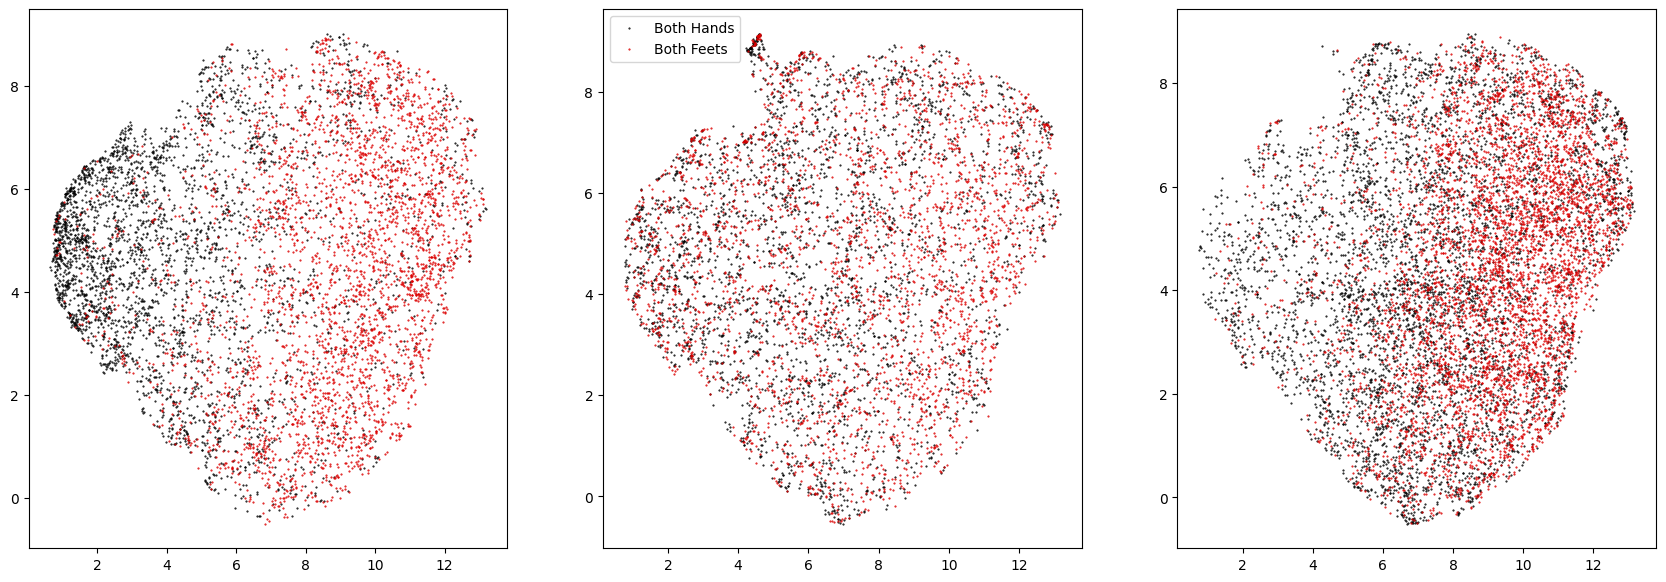

Train Accuracy: 77.57%
  Val Accuracy: 56.40%
 Test Accuracy: 69.10%


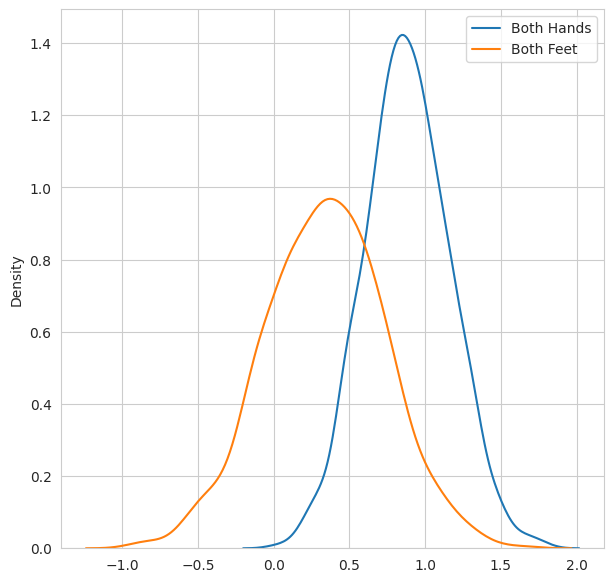

Done

_______________________
_______________________
Subj. no. 2
Reading data
Computing train embeddings


  0%|          | 0/34 [00:00<?, ?it/s]

Computing val embeddings


  0%|          | 0/39 [00:00<?, ?it/s]

Computing test embeddings


  0%|          | 0/24 [00:00<?, ?it/s]

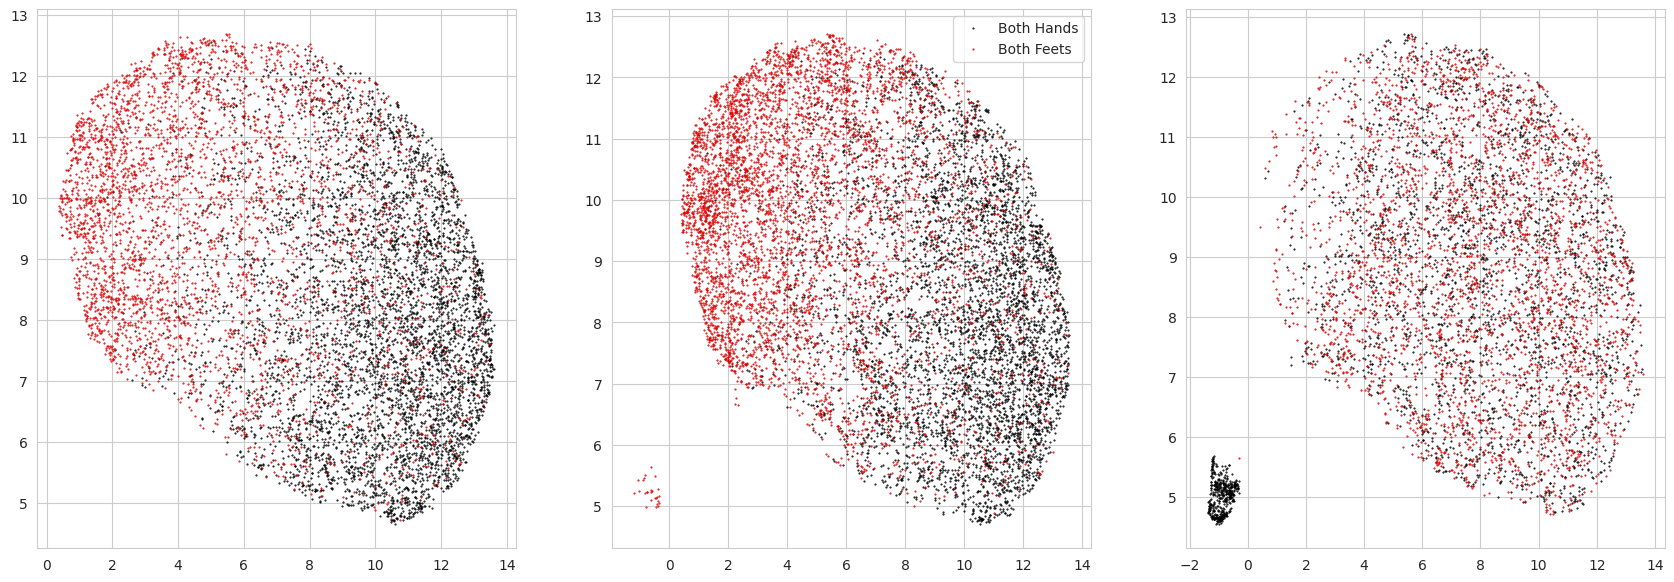

Train Accuracy: 79.75%
  Val Accuracy: 79.50%
 Test Accuracy: 46.84%


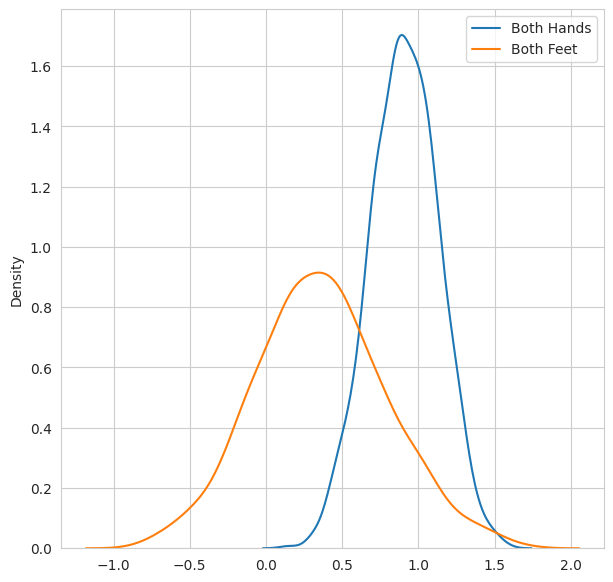

Done

_______________________
_______________________
Subj. no. 4
Reading data
Computing train embeddings


  0%|          | 0/34 [00:00<?, ?it/s]

Computing val embeddings


  0%|          | 0/19 [00:00<?, ?it/s]

Computing test embeddings


  0%|          | 0/43 [00:00<?, ?it/s]

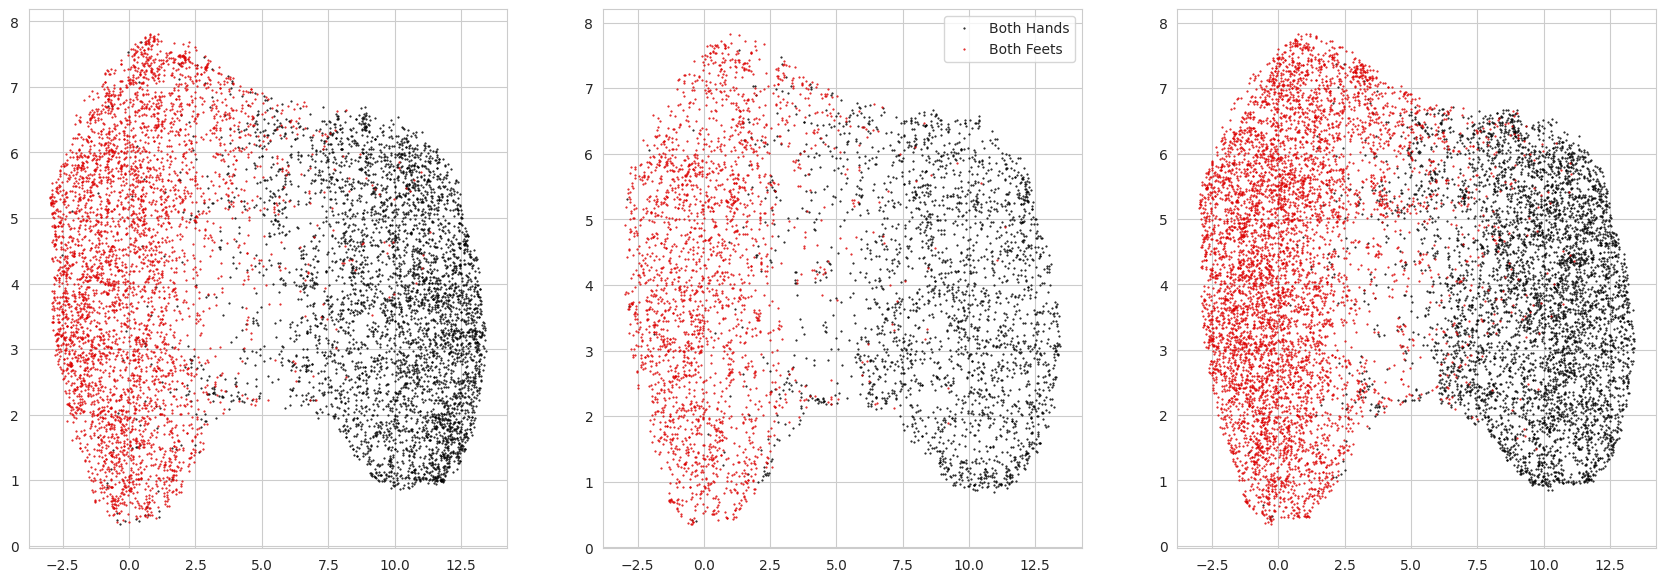

Train Accuracy: 95.53%
  Val Accuracy: 95.53%
 Test Accuracy: 93.71%


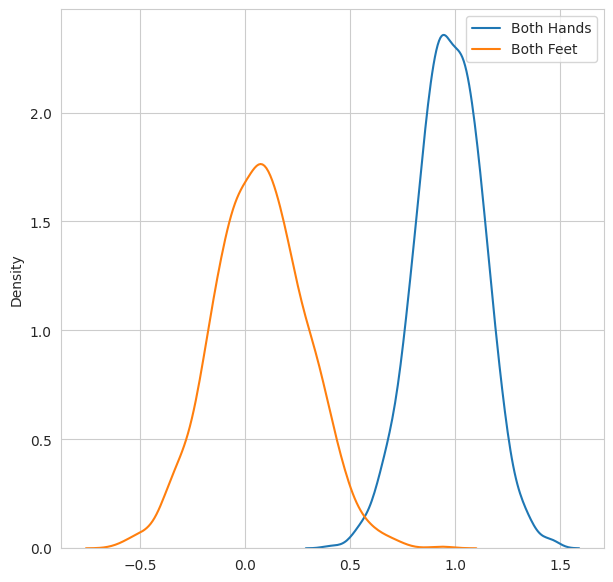

Done

_______________________
_______________________
Subj. no. 5
Reading data
Computing train embeddings


  0%|          | 0/35 [00:00<?, ?it/s]

Computing val embeddings


  0%|          | 0/30 [00:00<?, ?it/s]

Computing test embeddings


  0%|          | 0/40 [00:00<?, ?it/s]

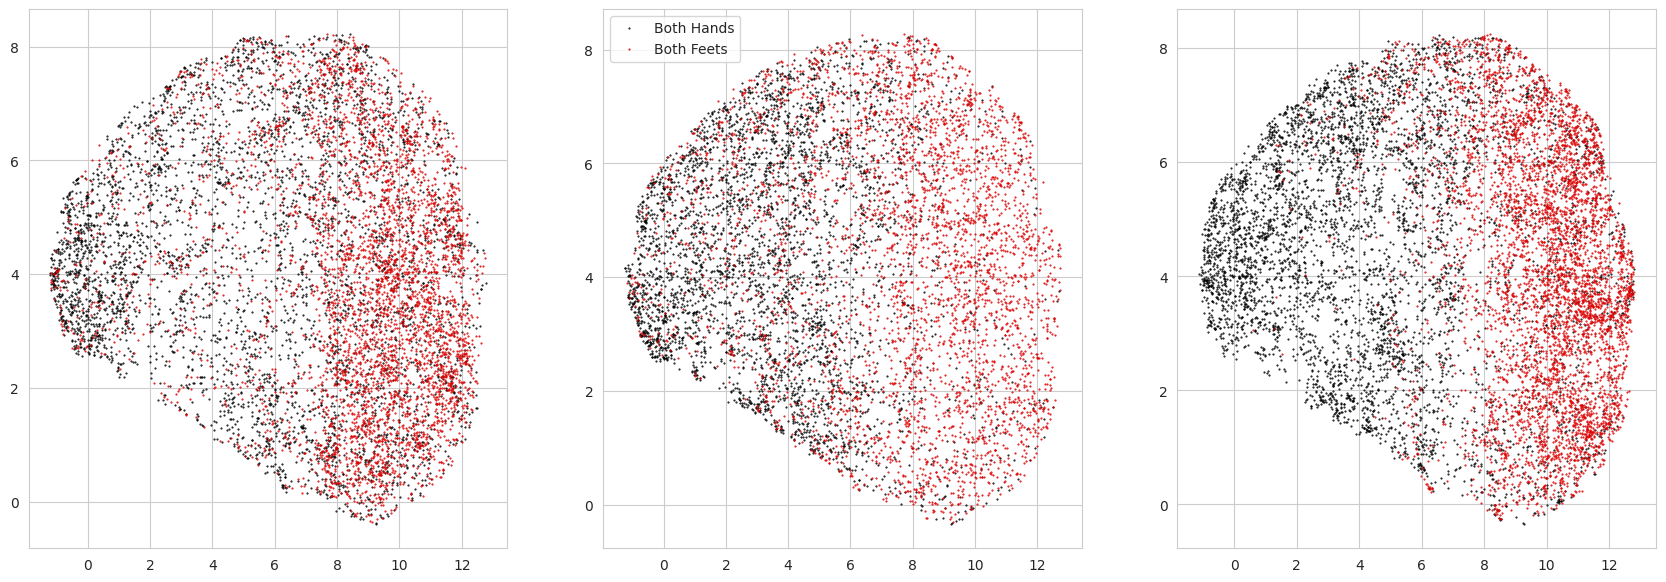

Train Accuracy: 72.12%
  Val Accuracy: 76.60%
 Test Accuracy: 87.21%


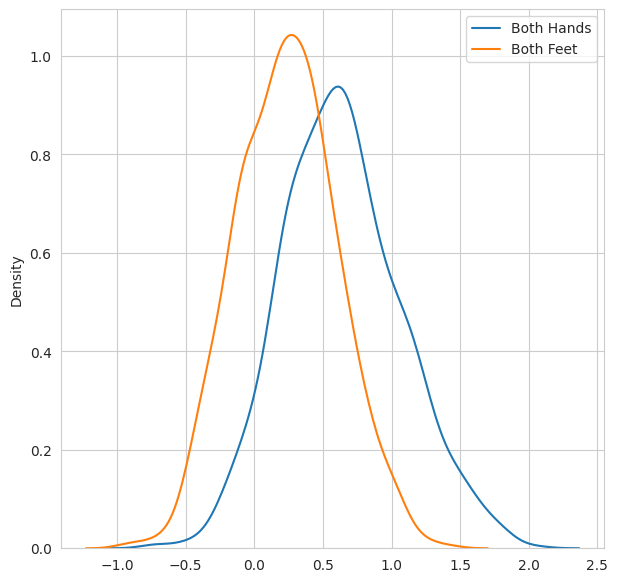

Done

_______________________
_______________________
Subj. no. 6
Reading data
Computing train embeddings


  0%|          | 0/39 [00:00<?, ?it/s]

Computing val embeddings


  0%|          | 0/27 [00:00<?, ?it/s]

Computing test embeddings


  0%|          | 0/29 [00:00<?, ?it/s]

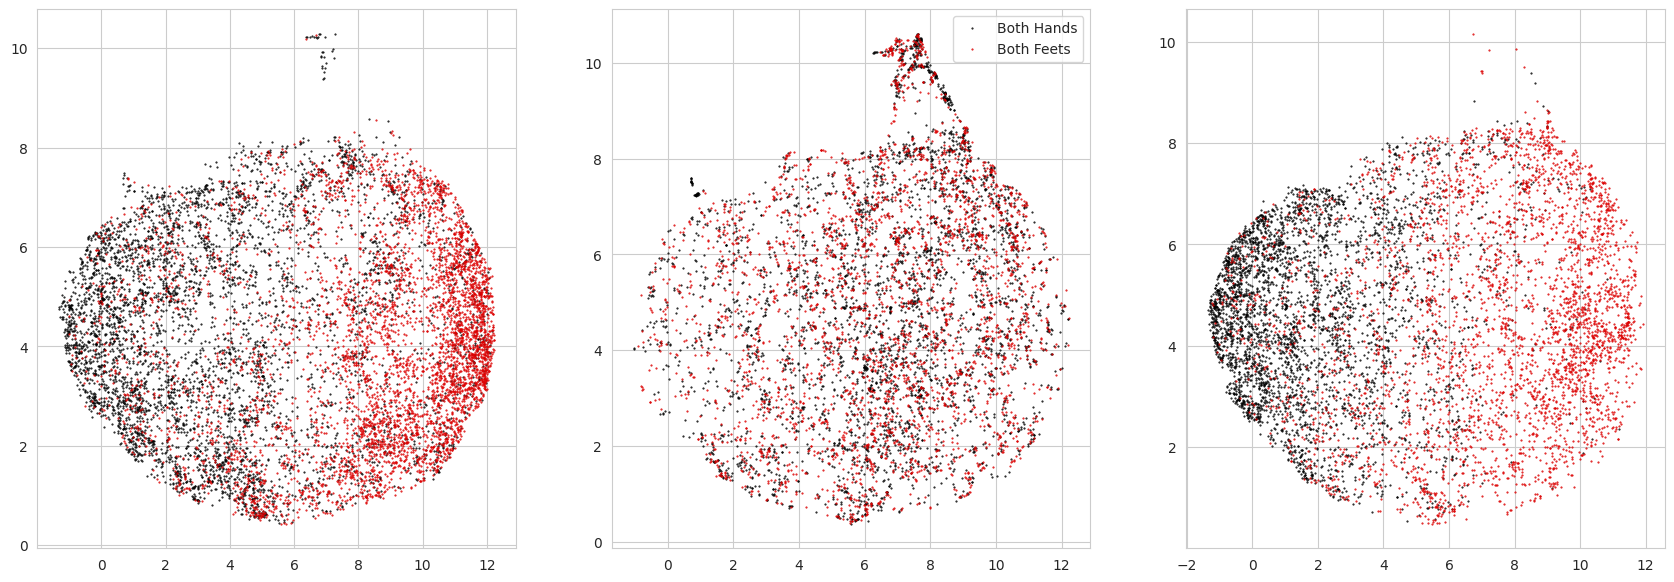

Train Accuracy: 76.39%
  Val Accuracy: 50.11%
 Test Accuracy: 76.75%


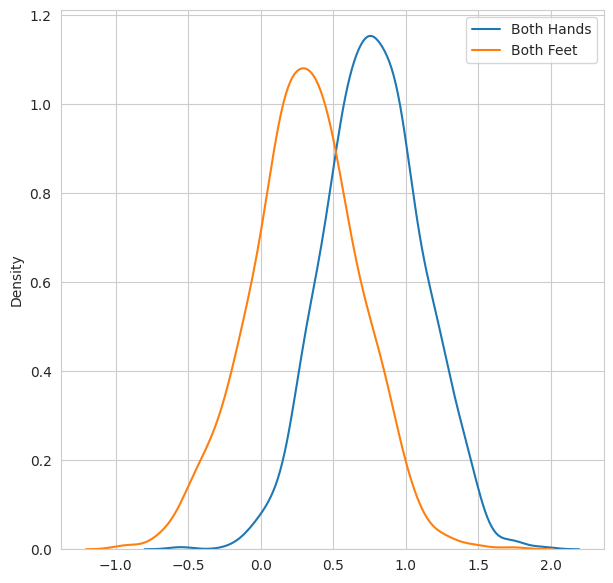

Done

_______________________
_______________________
Subj. no. 7
Reading data
Computing train embeddings


  0%|          | 0/34 [00:00<?, ?it/s]

Computing val embeddings


  0%|          | 0/30 [00:00<?, ?it/s]

Computing test embeddings


  0%|          | 0/27 [00:00<?, ?it/s]

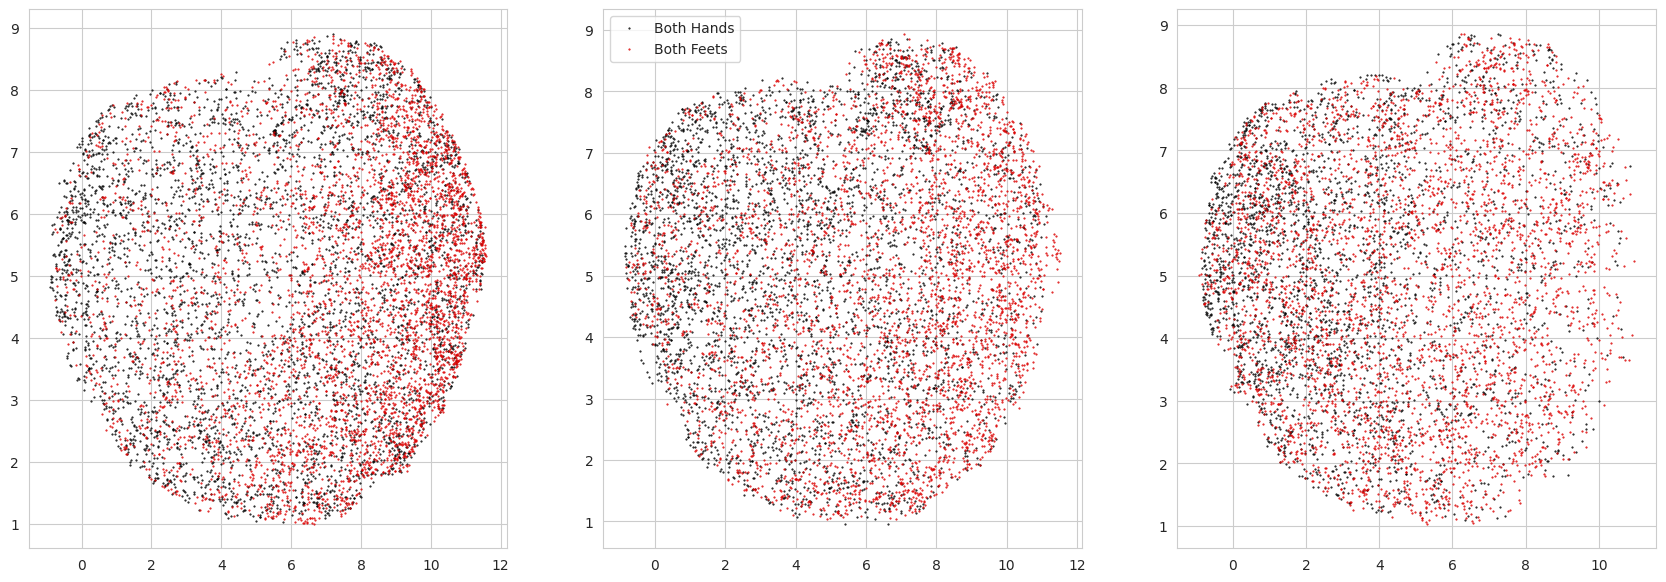

Train Accuracy: 64.43%
  Val Accuracy: 57.73%
 Test Accuracy: 56.83%


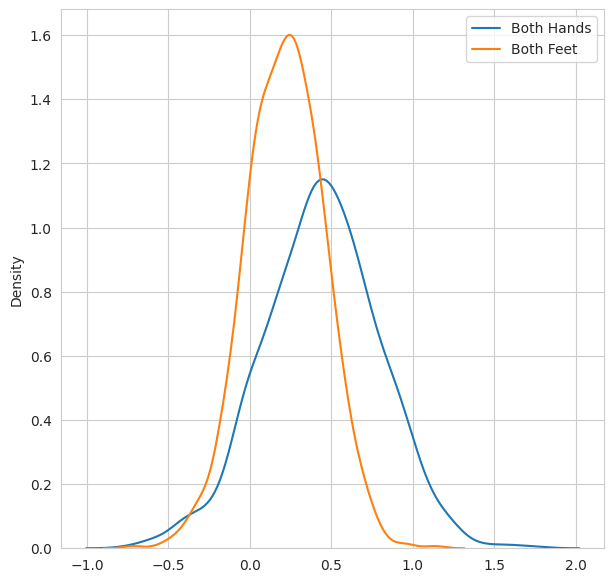

Done

_______________________


In [4]:
model.load_state_dict(torch.load(MODEL_CKPT))

for subj in '124567':
    print(f'_______________________\nSubj. no. {subj}')
    print('Reading data')
    train_set,val_set,test_set,_ = prepare_data(os.path.join(DATA_PATH,f'sbj{subj}_tr/preprocessed'),
                                              mean_std_path = MEAN_STD_PATH)

    train_sampler = BaseSampler(train_set, shuffle=False, batch_size=eval_batch_size)
    val_sampler = BaseSampler(val_set, batch_size=eval_batch_size)
    test_sampler = BaseSampler(test_set, shuffle=False, batch_size=eval_batch_size)

    print('Computing train embeddings')
    train_embeddings, train_labels = get_all_embeddings(train_sampler, model,device)
    train_embeddings = train_embeddings.cpu().numpy()
    train_labels = train_labels.cpu().numpy()
    
    print('Computing val embeddings')    
    val_embeddings, val_labels = get_all_embeddings(val_sampler, model,device)
    val_embeddings = val_embeddings.cpu().numpy()
    val_labels = val_labels.cpu().numpy()

    print('Computing test embeddings')    
    test_embeddings, test_labels = get_all_embeddings(test_sampler, model,device)
    test_embeddings = test_embeddings.cpu().numpy()
    test_labels = test_labels.cpu().numpy()

    ## Display embeddings in low-dimensional space
    tr_len = len(train_embeddings)
    val_len = tr_len+len(val_embeddings)
    all_embeddings = np.concatenate([train_embeddings,val_embeddings,test_embeddings])
    transform = UMAP(metric=metric)
    all_embeddings_umap = transform.fit_transform(all_embeddings)
    compare_embeddings(all_embeddings_umap[:tr_len],
                    all_embeddings_umap[tr_len:val_len],
                    train_labels,
                    val_labels,
                    embeddings3 = all_embeddings_umap[val_len:],
                    labels3=test_labels,label_mappings = LABEL_MAP)
    plt.show()

    ## Train and test a QDA classifier on learned embeddings
    clf = QuadraticDiscriminantAnalysis()
    clf.fit(train_embeddings, train_labels)

    train_preds = clf.predict(train_embeddings)
    print(f'Train Accuracy: {(train_preds==train_labels).mean()*100:.2f}%')
    val_preds = clf.predict(val_embeddings)
    print(f'  Val Accuracy: {(val_preds==val_labels).mean()*100:.2f}%')
    test_preds = clf.predict(test_embeddings)
    print(f' Test Accuracy: {(test_preds==test_labels).mean()*100:.2f}%')

    ## Display class probabilities
    train_probs = clf.predict_proba(train_embeddings)
    val_probs = clf.predict_proba(val_embeddings)
    test_probs = clf.predict_proba(test_embeddings)

    plt.figure(figsize=(7,7))
    sns.set_style('whitegrid')
    h_mu,h_std = train_probs[train_labels==0][:,0].mean(),train_probs[train_labels==0][:,0].std()
    f_mu,f_std = 1-train_probs[train_labels==1][:,1].mean(),train_probs[train_labels==1][:,1].std()

    sns.kdeplot(np.random.normal(h_mu,h_std,1000))
    sns.kdeplot(np.random.normal(f_mu,f_std,1000))
    plt.legend(['Both Hands','Both Feet'])
    plt.show()

    print('Done\n\n_______________________')

# Fine Tuning

In [31]:
NUM_EPOCHS = 3
N_SUPPORT = 50
N_QUERY = 100
N_EPISODES = 500
MAX_GRAD_NORM = 1
NUM_CLASSES = 2

LOG_INTERVAL = 1
LR = 1e-3
ES_PATIENCE = 5
ES_MIN_DELTA = 1e-4

learning_rate = LR
num_epochs = NUM_EPOCHS
n_support = N_SUPPORT
n_query = N_QUERY
n_episodes = N_EPISODES
n_classes = NUM_CLASSES
eval_batch_size = EVAL_BATCH_SIZE
max_grad_norm = MAX_GRAD_NORM

es_patience = ES_PATIENCE
es_min_delta = ES_MIN_DELTA
now = datetime.now().strftime('%Y%m%d_%H%M%S')

log_interval = LOG_INTERVAL
use_wandb = USE_WANDB
model_ckpt = MODEL_CKPT

In [45]:
def show_stats_and_plots(model,train_sampler,val_sampler,test_sampler,save_dir = None):
    print('Computing train embeddings')
    train_embeddings, train_labels = get_all_embeddings(train_sampler, model,device)
    train_embeddings = train_embeddings.cpu().numpy()
    train_labels = train_labels.cpu().numpy()

    print('Computing val embeddings')    
    val_embeddings, val_labels = get_all_embeddings(val_sampler, model,device)
    val_embeddings = val_embeddings.cpu().numpy()
    val_labels = val_labels.cpu().numpy()

    print('Computing test embeddings')    
    test_embeddings, test_labels = get_all_embeddings(test_sampler, model,device)
    test_embeddings = test_embeddings.cpu().numpy()
    test_labels = test_labels.cpu().numpy()

    ## Display embeddings in low-dimensional space
    tr_len = len(train_embeddings)
    val_len = tr_len+len(val_embeddings)
    all_embeddings = np.concatenate([train_embeddings,val_embeddings,test_embeddings])
    transform = UMAP(metric=metric)
    all_embeddings_umap = transform.fit_transform(all_embeddings)
    compare_embeddings(all_embeddings_umap[:tr_len],
                    all_embeddings_umap[tr_len:val_len],
                    train_labels,
                    val_labels,
                    embeddings3 = all_embeddings_umap[val_len:],
                    labels3=test_labels,label_mappings = LABEL_MAP)
    plt.show()

    ## Train and test a QDA classifier on learned embeddings
    clf = QuadraticDiscriminantAnalysis()
    clf.fit(train_embeddings, train_labels)

    train_preds = clf.predict(train_embeddings)
    print(f'Train Accuracy: {(train_preds==train_labels).mean()*100:.2f}%')
    val_preds = clf.predict(val_embeddings)
    print(f'  Val Accuracy: {(val_preds==val_labels).mean()*100:.2f}%')
    test_preds = clf.predict(test_embeddings)
    print(f' Test Accuracy: {(test_preds==test_labels).mean()*100:.2f}%')

    ## Display class probabilities
    train_probs = clf.predict_proba(train_embeddings)
    val_probs = clf.predict_proba(val_embeddings)
    test_probs = clf.predict_proba(test_embeddings)

    plt.figure(figsize=(7,7))
    sns.set_style('whitegrid')
    h_mu,h_std = train_probs[train_labels==0][:,0].mean(),train_probs[train_labels==0][:,0].std()
    f_mu,f_std = 1-train_probs[train_labels==1][:,1].mean(),train_probs[train_labels==1][:,1].std()
    if save_dir:
        dump(clf, os.path.join(save_dir,'qda.joblib') )
    sns.kdeplot(np.random.normal(h_mu,h_std,1000))
    sns.kdeplot(np.random.normal(f_mu,f_std,1000))
    plt.legend(['Both Hands','Both Feet'])
    plt.show()


## Subject 1

In [33]:
sbj = 1
model.load_state_dict(torch.load(model_ckpt))

train_set,val_set,test_set,norm = prepare_data(os.path.join(DATA_PATH,f'sbj{sbj}_tr/preprocessed'))

# Create samplers
episodic_sampler = EpisodicSampler(train_set,
                                n_support=n_support,
                                n_query=n_query,
                                n_episodes=n_episodes,
                                n_classes=n_classes)
train_sampler = BaseSampler(train_set, shuffle=False, batch_size=eval_batch_size)
val_sampler = BaseSampler(val_set, batch_size=eval_batch_size)
test_sampler = BaseSampler(test_set, shuffle=False, batch_size=eval_batch_size)

output_dir = os.path.join(OUT_PATH,f'sub{sbj}_{now}')
log_dir = os.path.join(LOG_PATH,f'sub{sbj}_{now}')

train(model,
    episodic_sampler,
    train_sampler,
    val_sampler,
    num_epochs,
    learning_rate=learning_rate,
    device=device,
    log_dir=log_dir,
    log_interval=log_interval,
    max_grad_norm=max_grad_norm,
    output_dir=output_dir,
    es_patience = es_patience,
    es_min_delta = es_min_delta,
    use_wandb = use_wandb,
    )
np.savez(os.path.join(output_dir,'mean_std.npz'),**norm)

Beginning training


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 1/3: Train loss: 0.3114068806171417 - Val loss: 0.8182295560836792 - Val acc: 0.5283018946647644


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 2/3: Train loss: 0.3460785150527954 - Val loss: 0.8545221090316772 - Val acc: 0.6000000238418579


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 3/3: Train loss: 0.3512848913669586 - Val loss: 0.8597195744514465 - Val acc: 0.5547170042991638
Finished training.


Computing train embeddings


  0%|          | 0/26 [00:00<?, ?it/s]

Computing val embeddings


  0%|          | 0/23 [00:00<?, ?it/s]

Computing test embeddings


  0%|          | 0/40 [00:00<?, ?it/s]

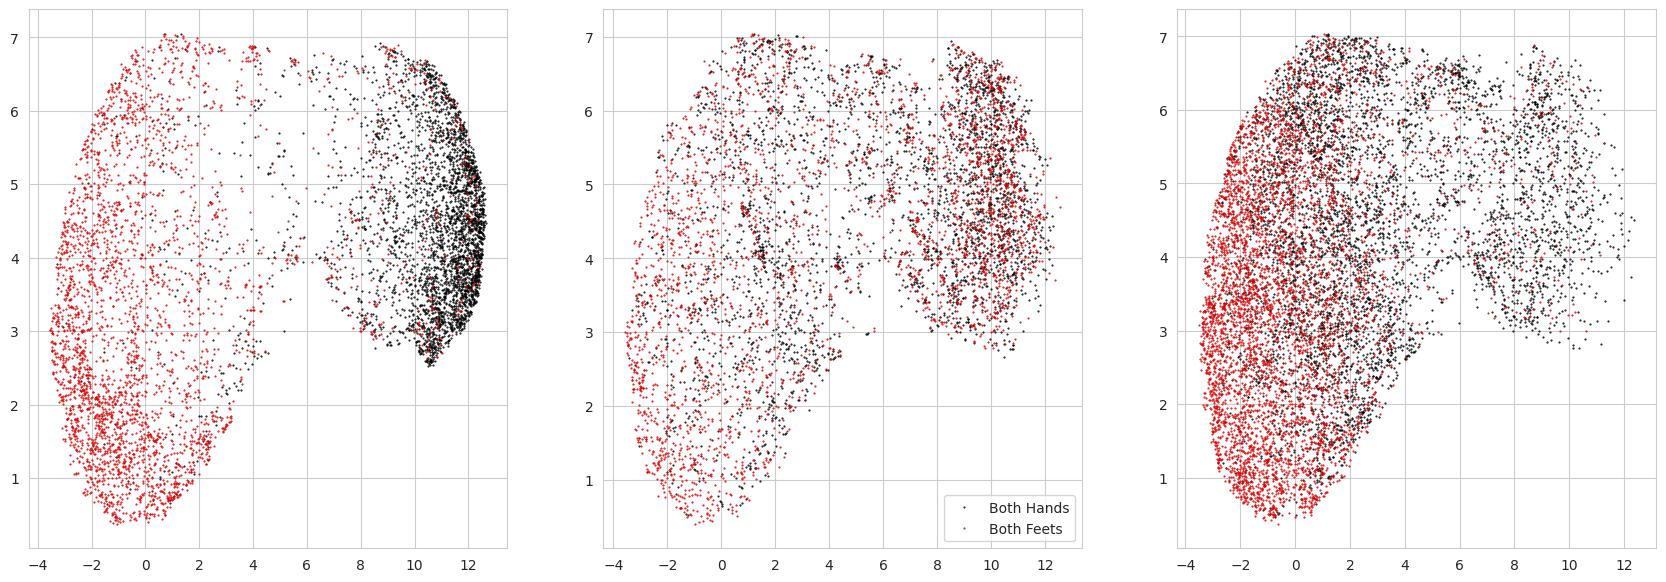

Train Accuracy: 89.94%
  Val Accuracy: 58.12%
 Test Accuracy: 63.39%


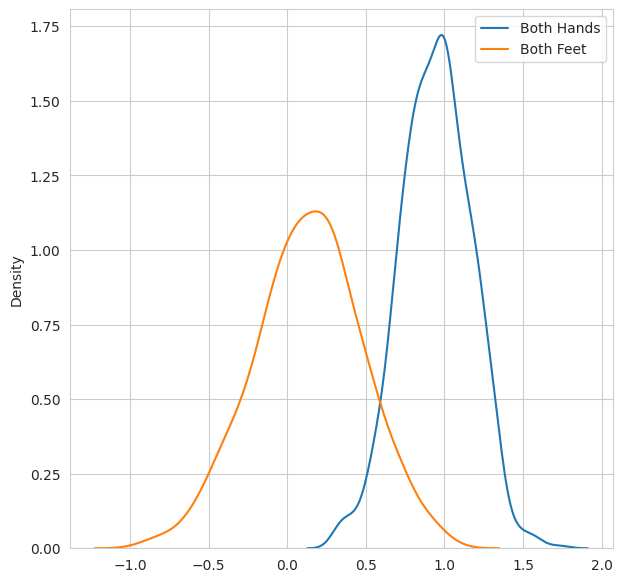

In [34]:
model.load_state_dict(torch.load(os.path.join(output_dir,'model.pt')))
show_stats_and_plots(model,train_sampler,val_sampler,test_sampler)

## Subject 2

In [35]:
sbj = 2
model.load_state_dict(torch.load(model_ckpt))

train_set,val_set,test_set,norm = prepare_data(os.path.join(DATA_PATH,f'sbj{sbj}_tr/preprocessed'))

# Create samplers
episodic_sampler = EpisodicSampler(train_set,
                                n_support=n_support,
                                n_query=n_query,
                                n_episodes=n_episodes,
                                n_classes=n_classes)
train_sampler = BaseSampler(train_set, shuffle=False, batch_size=eval_batch_size)
val_sampler = BaseSampler(val_set, batch_size=eval_batch_size)
test_sampler = BaseSampler(test_set, shuffle=False, batch_size=eval_batch_size)

output_dir = os.path.join(OUT_PATH,f'sub{sbj}_{now}')
log_dir = os.path.join(LOG_PATH,f'sub{sbj}_{now}')

train(model,
    episodic_sampler,
    train_sampler,
    val_sampler,
    num_epochs,
    learning_rate=learning_rate,
    device=device,
    log_dir=log_dir,
    log_interval=log_interval,
    max_grad_norm=max_grad_norm,
    output_dir=output_dir,
    es_patience = es_patience,
    es_min_delta = es_min_delta,
    use_wandb = use_wandb,
    )
np.savez(os.path.join(output_dir,'mean_std.npz'),**norm)

Beginning training


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch 1/3: Train loss: 0.4316094219684601 - Val loss: 0.34068092703819275 - Val acc: 0.8725868463516235


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch 2/3: Train loss: 0.3304477632045746 - Val loss: 0.3372960388660431 - Val acc: 0.8494208455085754


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch 3/3: Train loss: 0.4264541566371918 - Val loss: 0.33801382780075073 - Val acc: 0.8996138572692871
Finished training.


Computing train embeddings


  0%|          | 0/34 [00:00<?, ?it/s]

Computing val embeddings


  0%|          | 0/39 [00:00<?, ?it/s]

Computing test embeddings


  0%|          | 0/24 [00:00<?, ?it/s]

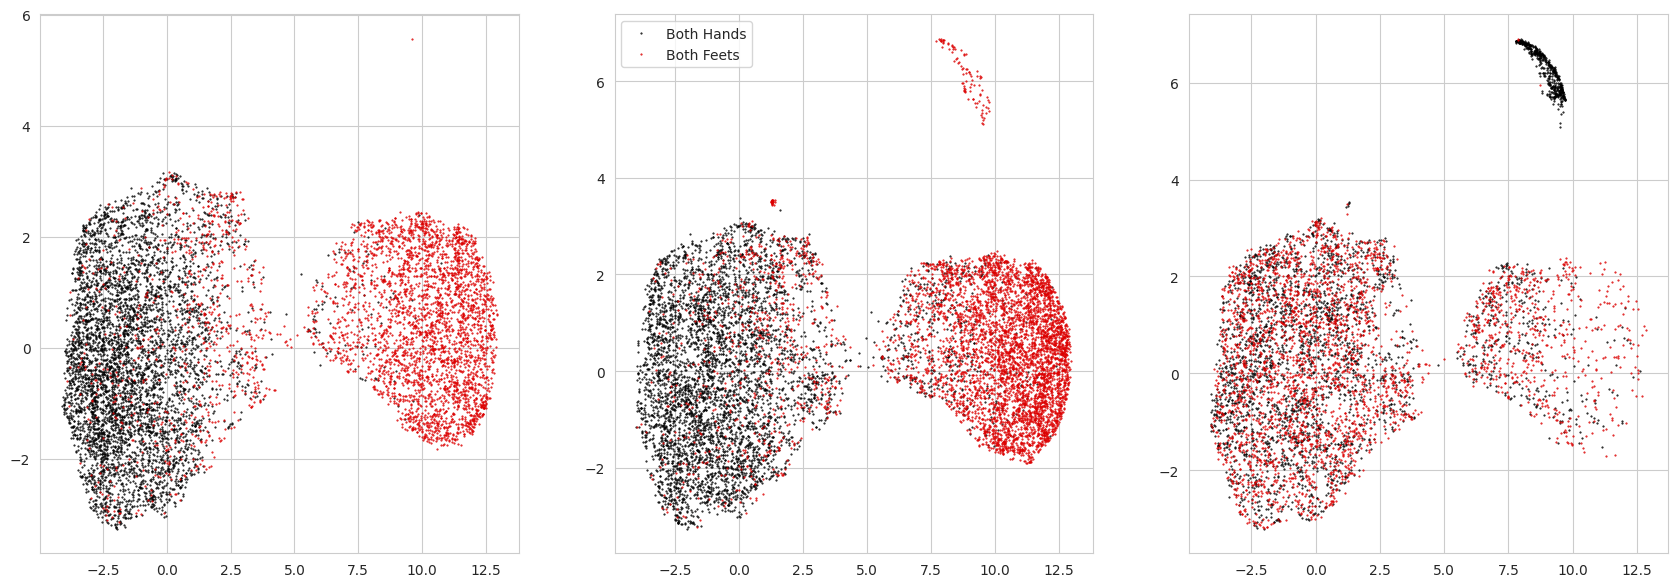

Train Accuracy: 89.64%
  Val Accuracy: 86.87%
 Test Accuracy: 47.10%


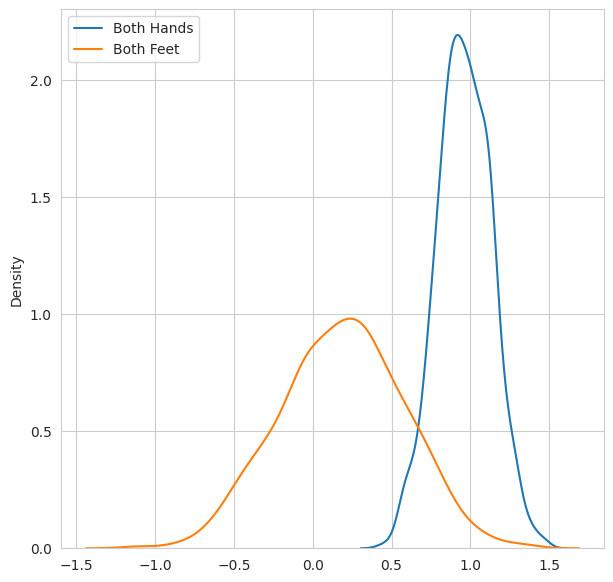

In [36]:
model.load_state_dict(torch.load(os.path.join(output_dir,'model.pt')))
show_stats_and_plots(model,train_sampler,val_sampler,test_sampler)

## Subject 4

In [37]:
sbj = 4
model.load_state_dict(torch.load(model_ckpt))

train_set,val_set,test_set,norm = prepare_data(os.path.join(DATA_PATH,f'sbj{sbj}_tr/preprocessed'))

# Create samplers
episodic_sampler = EpisodicSampler(train_set,
                                n_support=n_support,
                                n_query=n_query,
                                n_episodes=n_episodes,
                                n_classes=n_classes)
train_sampler = BaseSampler(train_set, shuffle=False, batch_size=eval_batch_size)
val_sampler = BaseSampler(val_set, batch_size=eval_batch_size)
test_sampler = BaseSampler(test_set, shuffle=False, batch_size=eval_batch_size)

output_dir = os.path.join(OUT_PATH,f'sub{sbj}_{now}')
log_dir = os.path.join(LOG_PATH,f'sub{sbj}_{now}')

train(model,
    episodic_sampler,
    train_sampler,
    val_sampler,
    num_epochs,
    learning_rate=learning_rate,
    device=device,
    log_dir=log_dir,
    log_interval=log_interval,
    max_grad_norm=max_grad_norm,
    output_dir=output_dir,
    es_patience = es_patience,
    es_min_delta = es_min_delta,
    use_wandb = use_wandb,
    )
np.savez(os.path.join(output_dir,'mean_std.npz'),**norm)

Beginning training


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 1/3: Train loss: 0.2597424387931824 - Val loss: 0.17321957647800446 - Val acc: 0.9765625


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 2/3: Train loss: 0.1724981814622879 - Val loss: 0.16762466728687286 - Val acc: 0.98828125


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 3/3: Train loss: 0.17752648890018463 - Val loss: 0.1629173904657364 - Val acc: 0.984375
Finished training.


Computing train embeddings


  0%|          | 0/34 [00:00<?, ?it/s]

Computing val embeddings


  0%|          | 0/19 [00:00<?, ?it/s]

Computing test embeddings


  0%|          | 0/43 [00:00<?, ?it/s]

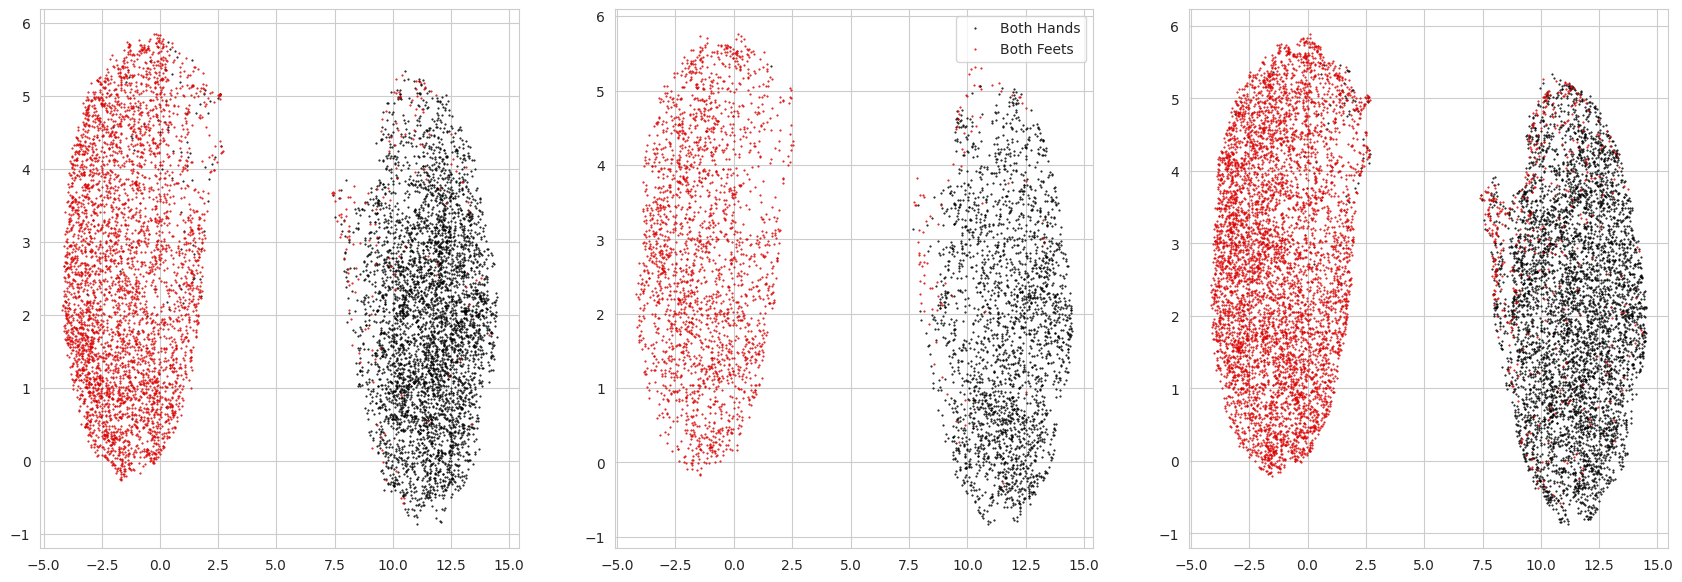

Train Accuracy: 97.23%
  Val Accuracy: 97.79%
 Test Accuracy: 94.75%


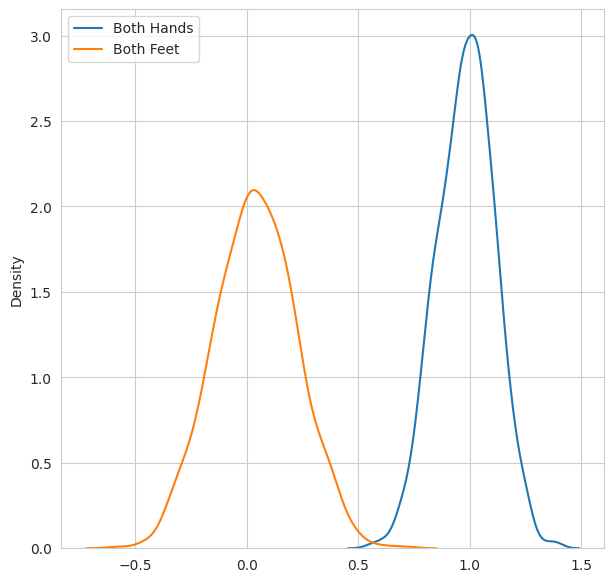

In [38]:
model.load_state_dict(torch.load(os.path.join(output_dir,'model.pt')))
show_stats_and_plots(model,train_sampler,val_sampler,test_sampler)

## Subject 5

In [39]:
sbj = 5
model.load_state_dict(torch.load(model_ckpt))

train_set,val_set,test_set,norm = prepare_data(os.path.join(DATA_PATH,f'sbj{sbj}_tr/preprocessed'))

# Create samplers
episodic_sampler = EpisodicSampler(train_set,
                                n_support=n_support,
                                n_query=n_query,
                                n_episodes=n_episodes,
                                n_classes=n_classes)
train_sampler = BaseSampler(train_set, shuffle=False, batch_size=eval_batch_size)
val_sampler = BaseSampler(val_set, batch_size=eval_batch_size)
test_sampler = BaseSampler(test_set, shuffle=False, batch_size=eval_batch_size)

output_dir = os.path.join(OUT_PATH,f'sub{sbj}_{now}')
log_dir = os.path.join(LOG_PATH,f'sub{sbj}_{now}')

train(model,
    episodic_sampler,
    train_sampler,
    val_sampler,
    num_epochs,
    learning_rate=learning_rate,
    device=device,
    log_dir=log_dir,
    log_interval=log_interval,
    max_grad_norm=max_grad_norm,
    output_dir=output_dir,
    es_patience = es_patience,
    es_min_delta = es_min_delta,
    use_wandb = use_wandb,
    )
np.savez(os.path.join(output_dir,'mean_std.npz'),**norm)

Beginning training


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/3: Train loss: 0.5686613917350769 - Val loss: 0.5221735835075378 - Val acc: 0.7374517321586609


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 2/3: Train loss: 0.5222394466400146 - Val loss: 0.5696066617965698 - Val acc: 0.7104247212409973


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 3/3: Train loss: 0.5674533247947693 - Val loss: 0.5637158155441284 - Val acc: 0.7297297120094299
Finished training.


Computing train embeddings


  0%|          | 0/35 [00:00<?, ?it/s]

Computing val embeddings


  0%|          | 0/30 [00:00<?, ?it/s]

Computing test embeddings


  0%|          | 0/40 [00:00<?, ?it/s]

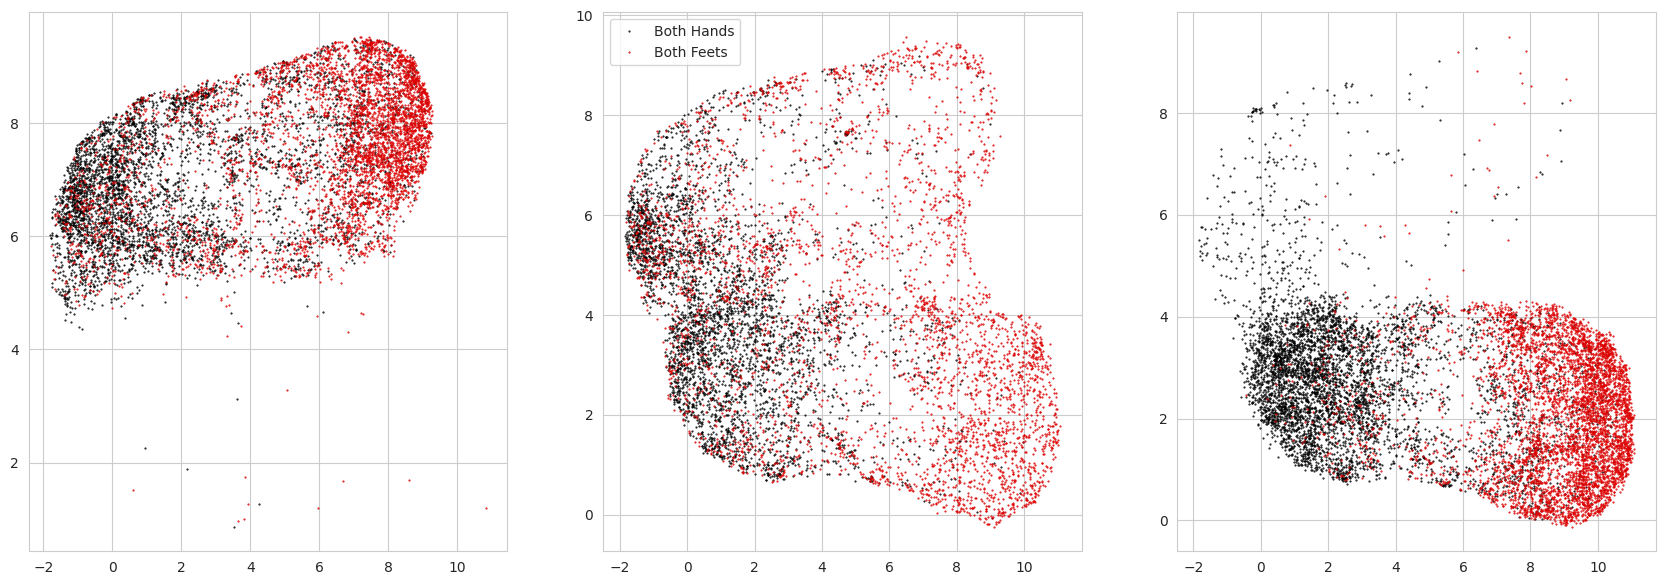

Train Accuracy: 75.26%
  Val Accuracy: 72.81%
 Test Accuracy: 85.93%


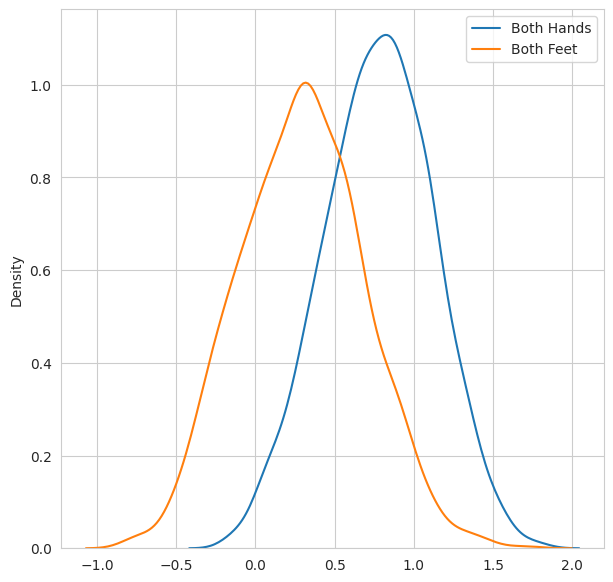

In [40]:
model.load_state_dict(torch.load(os.path.join(output_dir,'model.pt')))
show_stats_and_plots(model,train_sampler,val_sampler,test_sampler)

## Subject 6

In [41]:
sbj = 6
model.load_state_dict(torch.load(model_ckpt))

train_set,val_set,test_set,norm = prepare_data(os.path.join(DATA_PATH,f'sbj{sbj}_tr/preprocessed'))

# Create samplers
episodic_sampler = EpisodicSampler(train_set,
                                n_support=n_support,
                                n_query=n_query,
                                n_episodes=n_episodes,
                                n_classes=n_classes)
train_sampler = BaseSampler(train_set, shuffle=False, batch_size=eval_batch_size)
val_sampler = BaseSampler(val_set, batch_size=eval_batch_size)
test_sampler = BaseSampler(test_set, shuffle=False, batch_size=eval_batch_size)

output_dir = os.path.join(OUT_PATH,f'sub{sbj}_{now}')
log_dir = os.path.join(LOG_PATH,f'sub{sbj}_{now}')

train(model,
    episodic_sampler,
    train_sampler,
    val_sampler,
    num_epochs,
    learning_rate=learning_rate,
    device=device,
    log_dir=log_dir,
    log_interval=log_interval,
    max_grad_norm=max_grad_norm,
    output_dir=output_dir,
    es_patience = es_patience,
    es_min_delta = es_min_delta,
    use_wandb = use_wandb,
    )
np.savez(os.path.join(output_dir,'mean_std.npz'),**norm)

Beginning training


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 1/3: Train loss: 0.543104350566864 - Val loss: 0.8280138969421387 - Val acc: 0.49042144417762756


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 2/3: Train loss: 0.4694972336292267 - Val loss: 0.8393121361732483 - Val acc: 0.501915693283081


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 3/3: Train loss: 0.3804907202720642 - Val loss: 0.8539853692054749 - Val acc: 0.5287356376647949
Finished training.


Computing train embeddings


  0%|          | 0/39 [00:00<?, ?it/s]

Computing val embeddings


  0%|          | 0/27 [00:00<?, ?it/s]

Computing test embeddings


  0%|          | 0/29 [00:00<?, ?it/s]

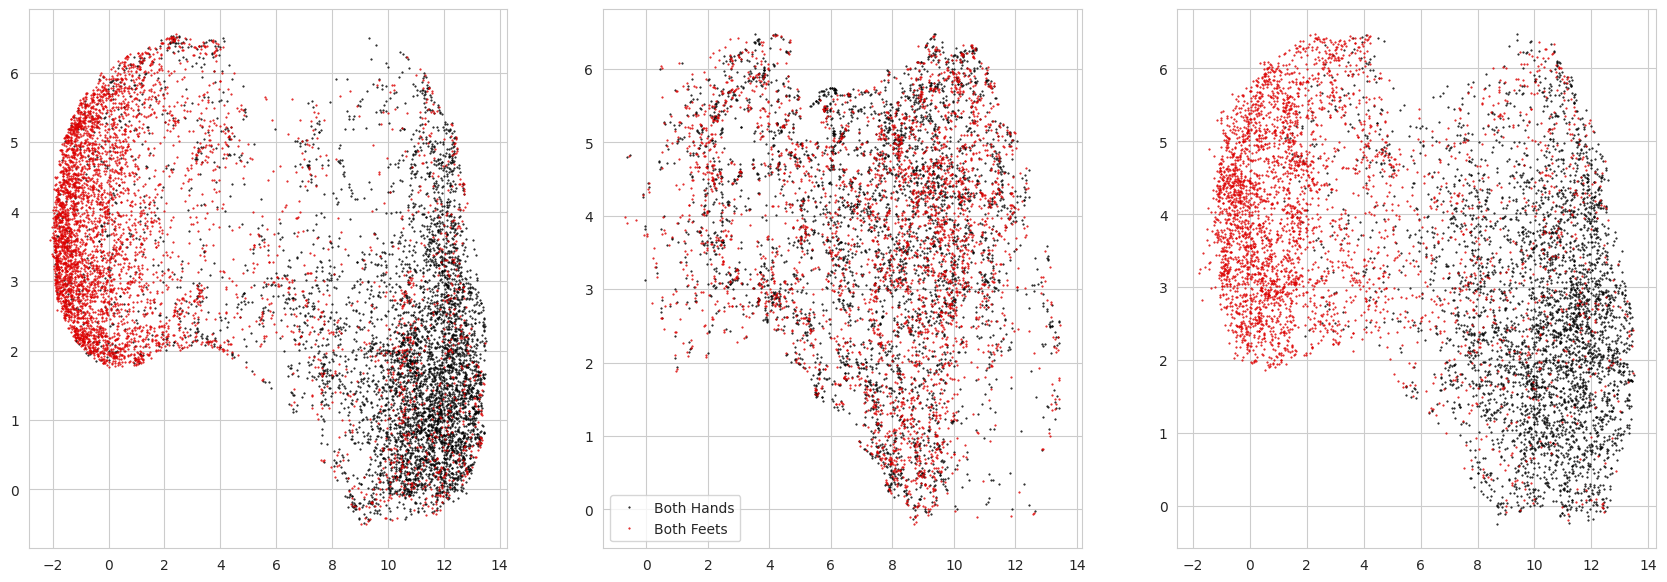

Train Accuracy: 82.51%
  Val Accuracy: 51.47%
 Test Accuracy: 84.21%


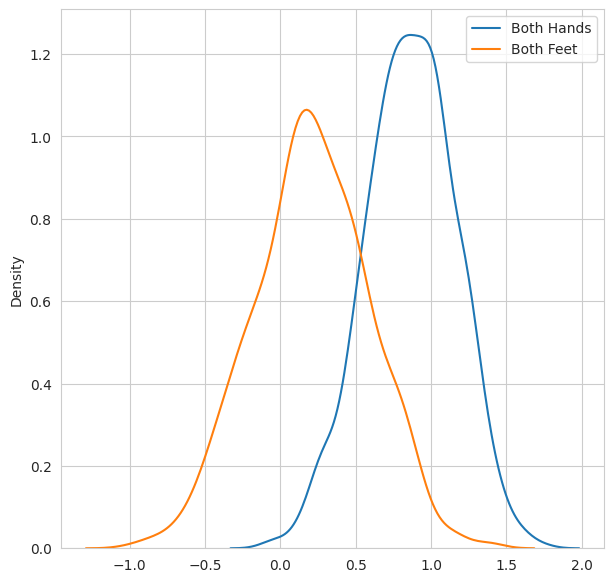

In [42]:
model.load_state_dict(torch.load(os.path.join(output_dir,'model.pt')))
show_stats_and_plots(model,train_sampler,val_sampler,test_sampler)

## Subject 7

In [43]:
sbj = 7
model.load_state_dict(torch.load(model_ckpt))

train_set,val_set,test_set,norm = prepare_data(os.path.join(DATA_PATH,f'sbj{sbj}_tr/preprocessed'))

# Create samplers
episodic_sampler = EpisodicSampler(train_set,
                                n_support=n_support,
                                n_query=n_query,
                                n_episodes=n_episodes,
                                n_classes=n_classes)
train_sampler = BaseSampler(train_set, shuffle=False, batch_size=eval_batch_size)
val_sampler = BaseSampler(val_set, batch_size=eval_batch_size)
test_sampler = BaseSampler(test_set, shuffle=False, batch_size=eval_batch_size)

output_dir = os.path.join(OUT_PATH,f'sub{sbj}_{now}')
log_dir = os.path.join(LOG_PATH,f'sub{sbj}_{now}')

train(model,
    episodic_sampler,
    train_sampler,
    val_sampler,
    num_epochs,
    learning_rate=learning_rate,
    device=device,
    log_dir=log_dir,
    log_interval=log_interval,
    max_grad_norm=max_grad_norm,
    output_dir=output_dir,
    es_patience = es_patience,
    es_min_delta = es_min_delta,
    use_wandb = use_wandb,
    )
np.savez(os.path.join(output_dir,'mean_std.npz'),**norm)

Beginning training


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/3: Train loss: 0.6247910857200623 - Val loss: 0.6810086369514465 - Val acc: 0.6539924144744873


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 2/3: Train loss: 0.5497217774391174 - Val loss: 0.7127032279968262 - Val acc: 0.6235741376876831


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 3/3: Train loss: 0.567277193069458 - Val loss: 0.7306676506996155 - Val acc: 0.6045627593994141
Finished training.


Computing train embeddings


  0%|          | 0/34 [00:00<?, ?it/s]

Computing val embeddings


  0%|          | 0/30 [00:00<?, ?it/s]

Computing test embeddings


  0%|          | 0/27 [00:00<?, ?it/s]

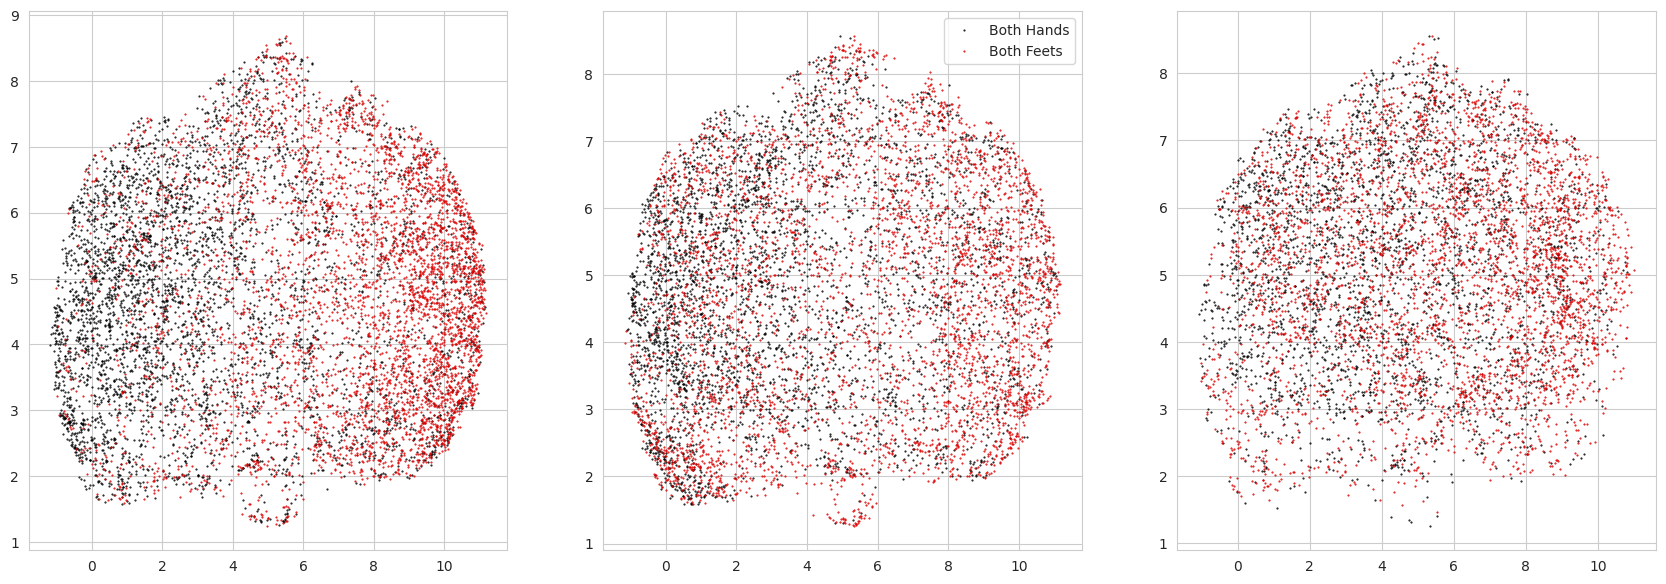

Train Accuracy: 67.63%
  Val Accuracy: 58.59%
 Test Accuracy: 55.50%


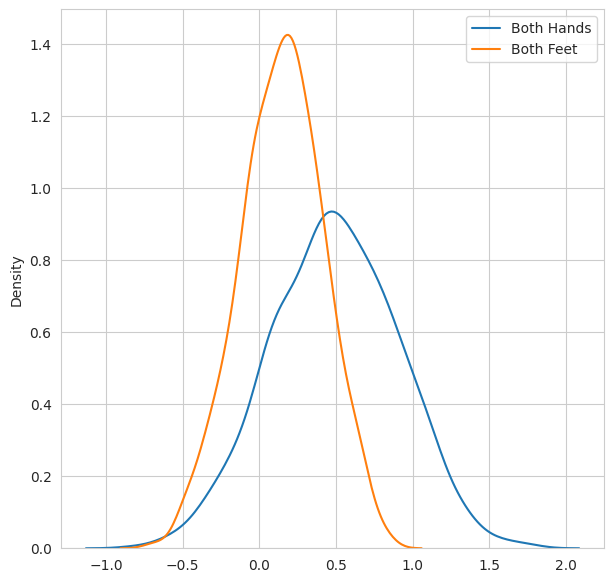

In [44]:
model.load_state_dict(torch.load(os.path.join(output_dir,'model.pt')))
show_stats_and_plots(model,train_sampler,val_sampler,test_sampler)

Computing train embeddings


  0%|          | 0/26 [00:00<?, ?it/s]

Computing val embeddings


  0%|          | 0/23 [00:00<?, ?it/s]

Computing test embeddings


  0%|          | 0/40 [00:00<?, ?it/s]

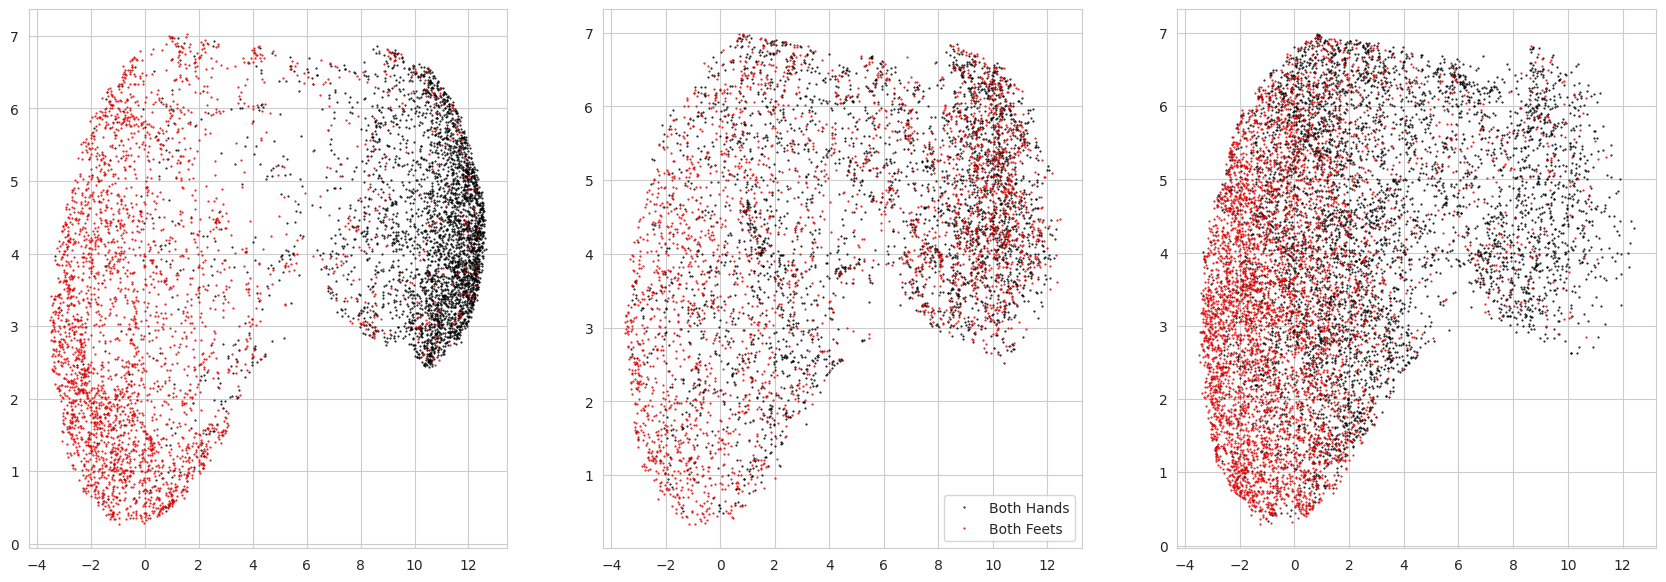

Train Accuracy: 89.94%
  Val Accuracy: 58.12%
 Test Accuracy: 63.39%


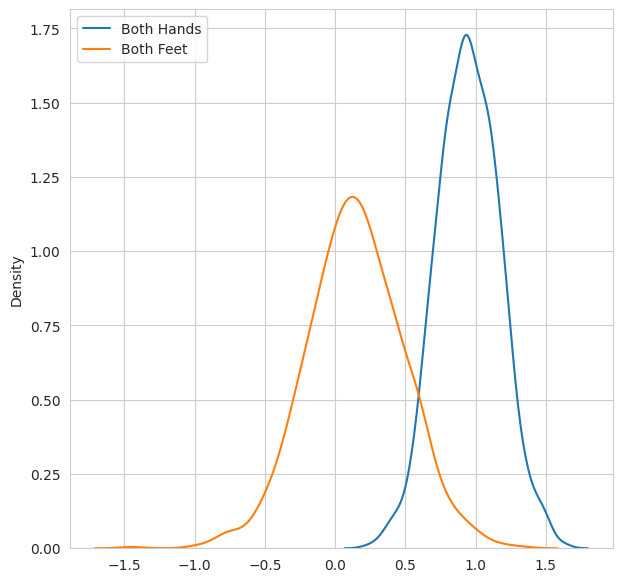

Computing train embeddings


  0%|          | 0/34 [00:00<?, ?it/s]

Computing val embeddings


  0%|          | 0/39 [00:00<?, ?it/s]

Computing test embeddings


  0%|          | 0/24 [00:00<?, ?it/s]

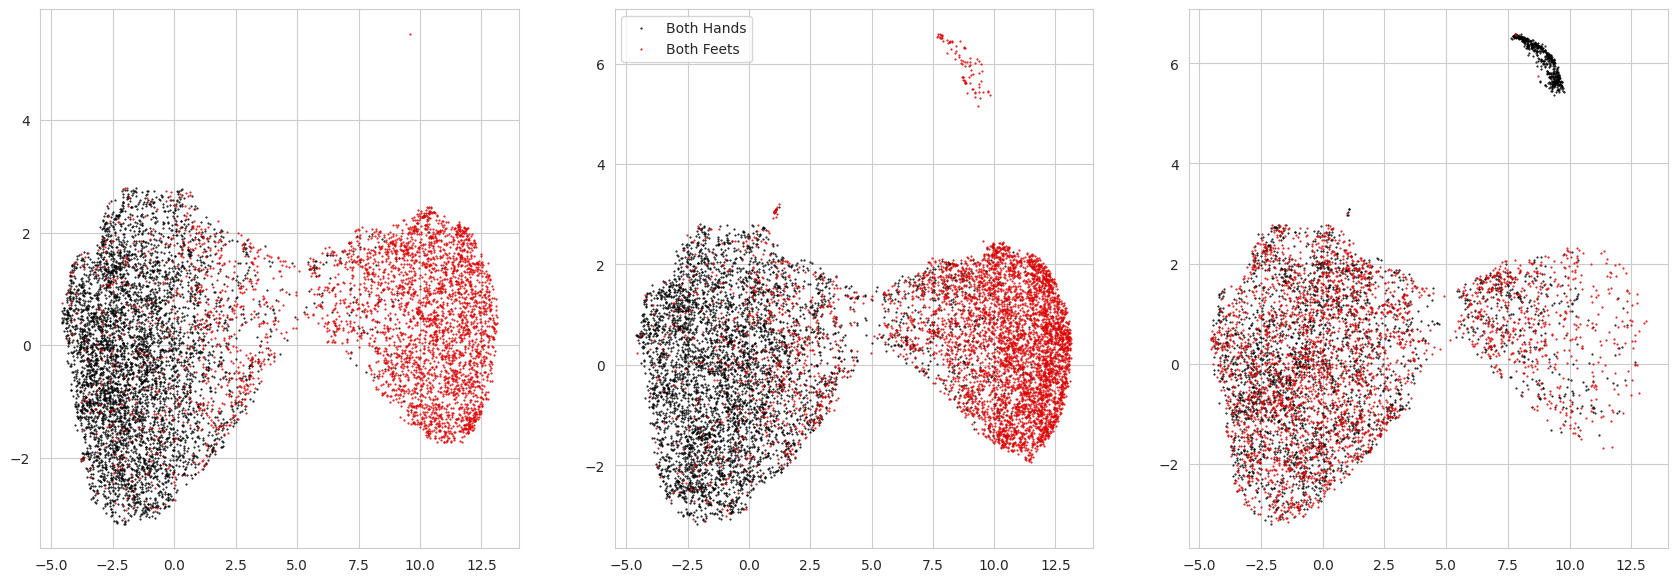

Train Accuracy: 89.64%
  Val Accuracy: 86.87%
 Test Accuracy: 47.10%


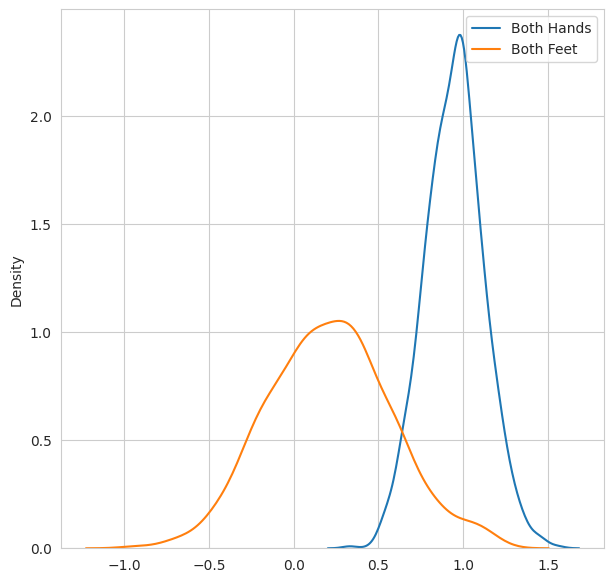

Computing train embeddings


  0%|          | 0/34 [00:00<?, ?it/s]

Computing val embeddings


  0%|          | 0/19 [00:00<?, ?it/s]

Computing test embeddings


  0%|          | 0/43 [00:00<?, ?it/s]

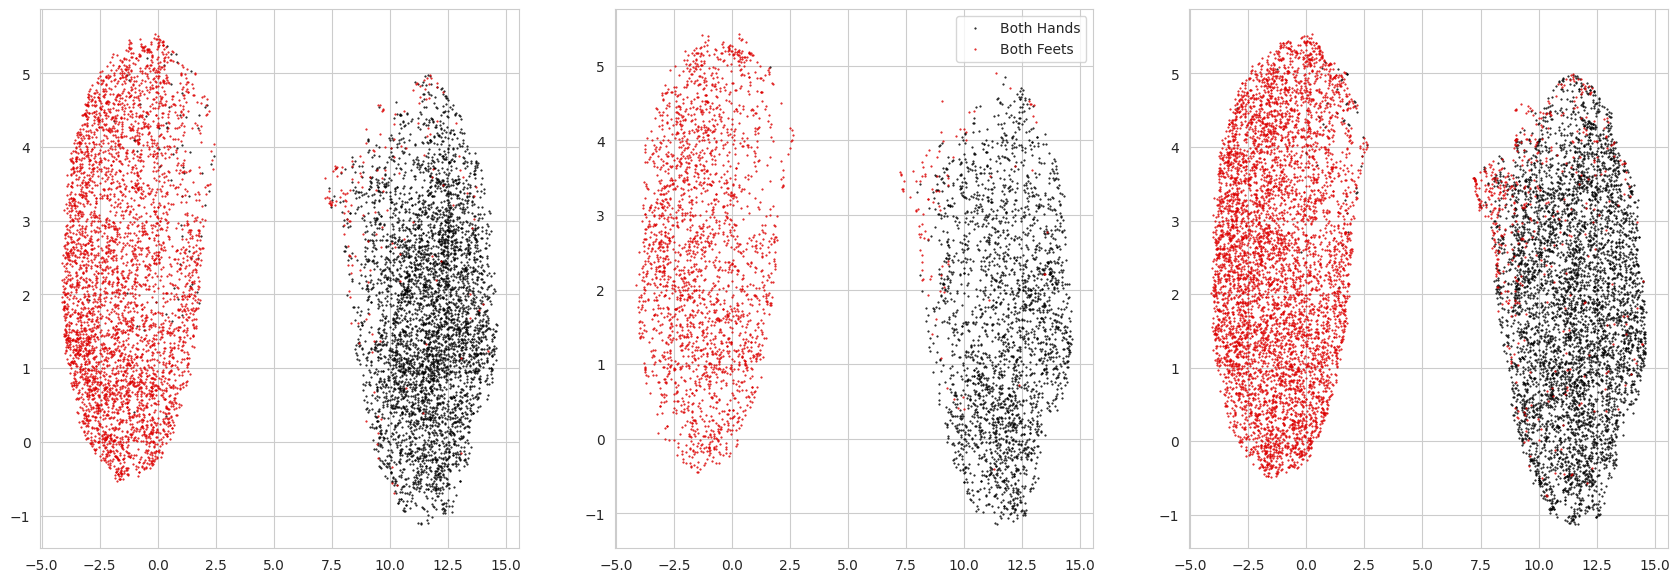

Train Accuracy: 97.23%
  Val Accuracy: 97.79%
 Test Accuracy: 94.75%


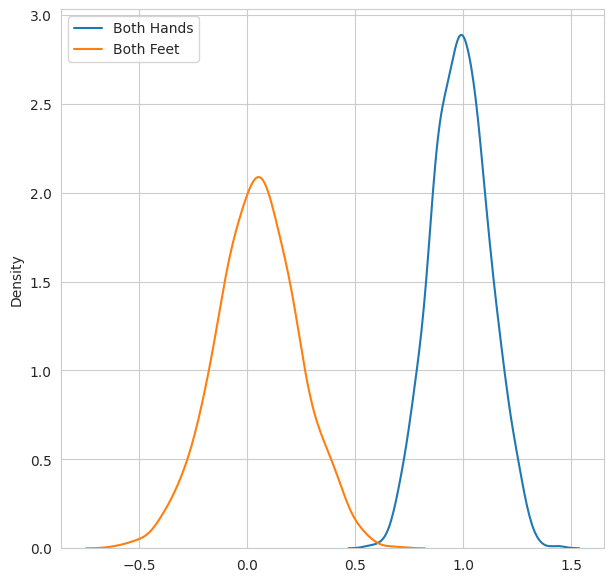

Computing train embeddings


  0%|          | 0/35 [00:00<?, ?it/s]

Computing val embeddings


  0%|          | 0/30 [00:00<?, ?it/s]

Computing test embeddings


  0%|          | 0/40 [00:00<?, ?it/s]

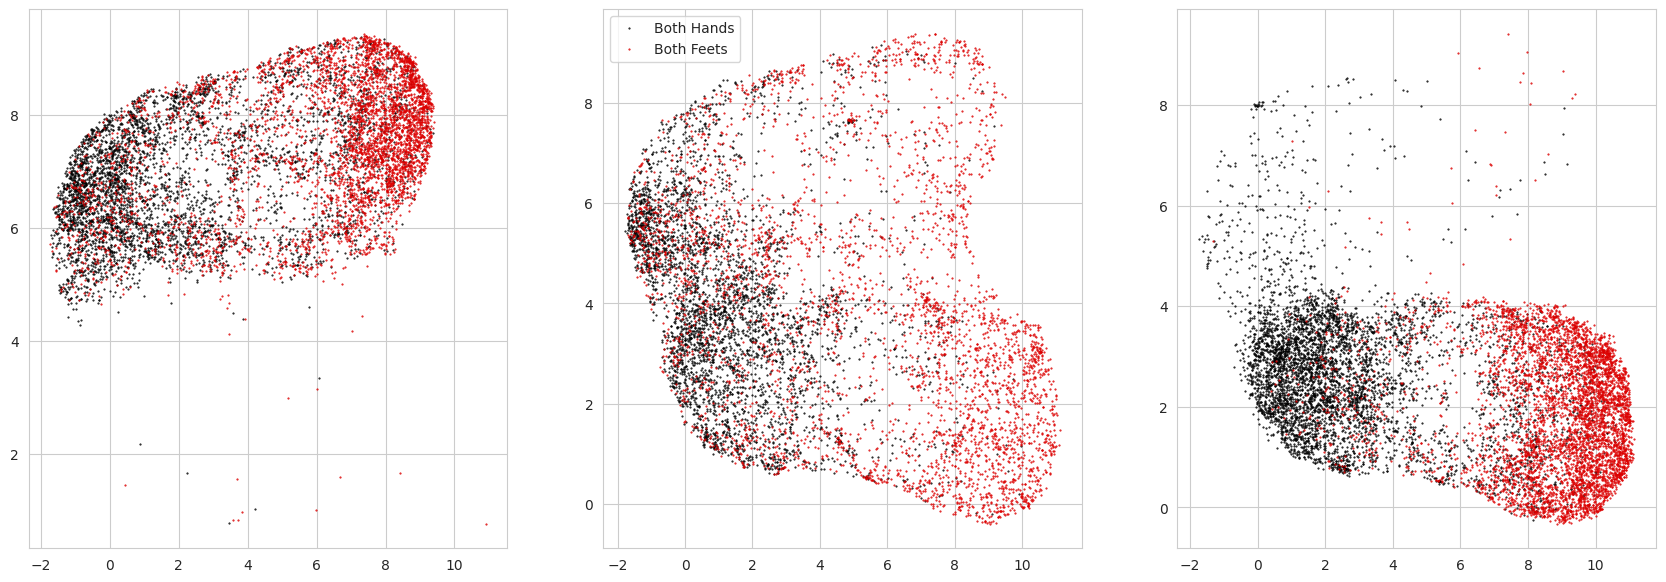

Train Accuracy: 75.26%
  Val Accuracy: 72.81%
 Test Accuracy: 85.93%


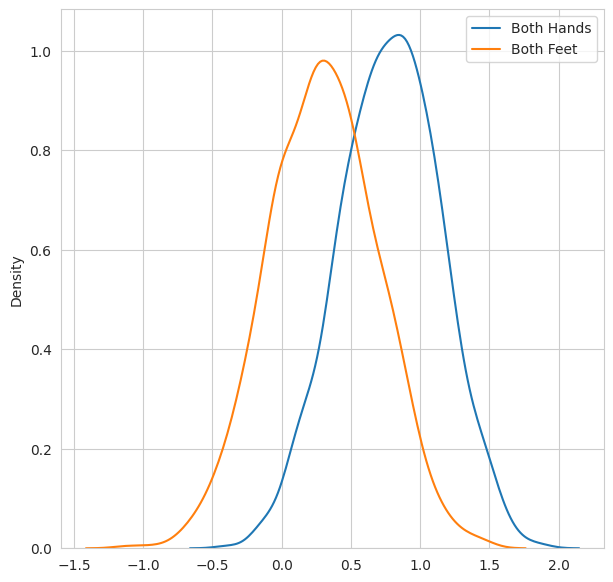

Computing train embeddings


  0%|          | 0/39 [00:00<?, ?it/s]

Computing val embeddings


  0%|          | 0/27 [00:00<?, ?it/s]

Computing test embeddings


  0%|          | 0/29 [00:00<?, ?it/s]

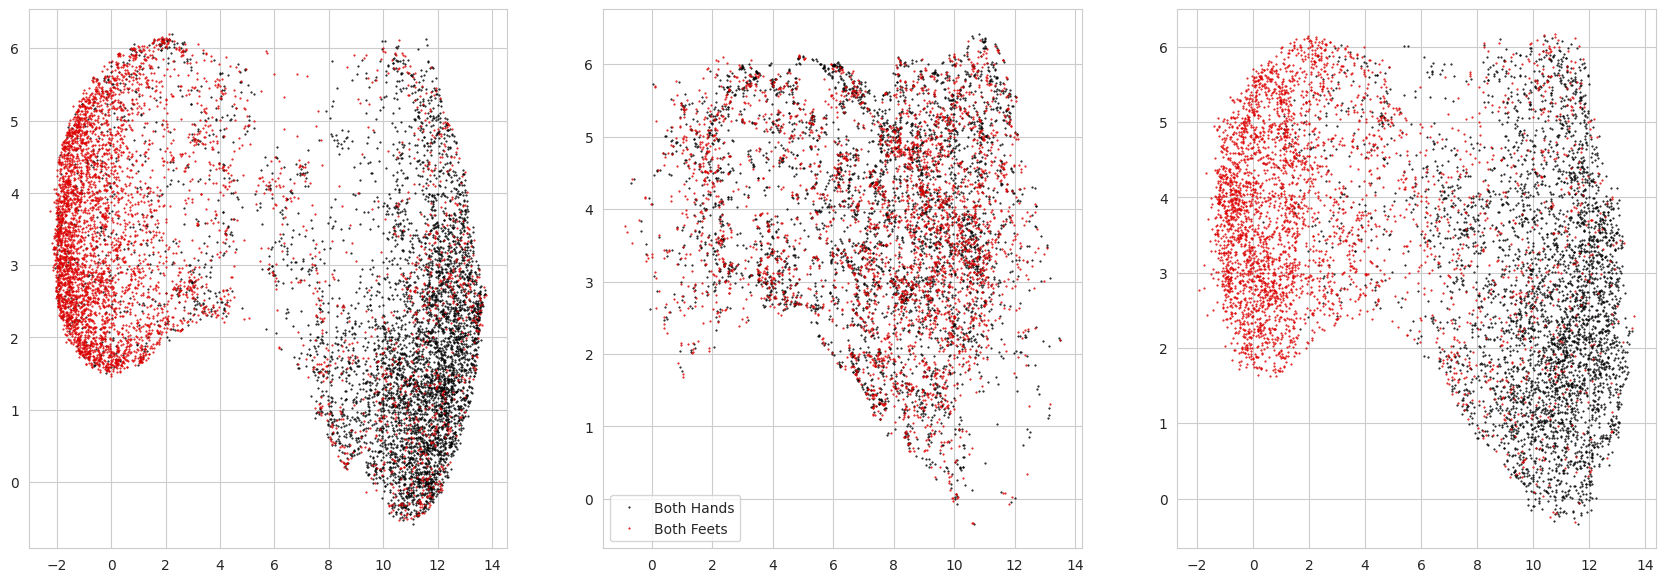

Train Accuracy: 82.51%
  Val Accuracy: 51.47%
 Test Accuracy: 84.21%


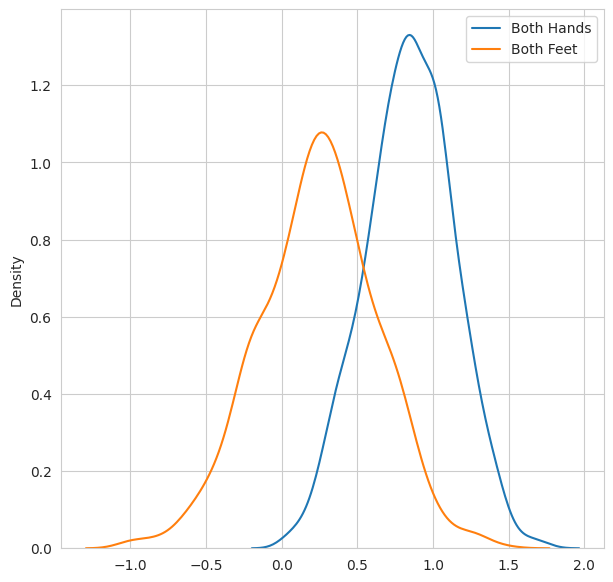

Computing train embeddings


  0%|          | 0/34 [00:00<?, ?it/s]

Computing val embeddings


  0%|          | 0/30 [00:00<?, ?it/s]

Computing test embeddings


  0%|          | 0/27 [00:00<?, ?it/s]

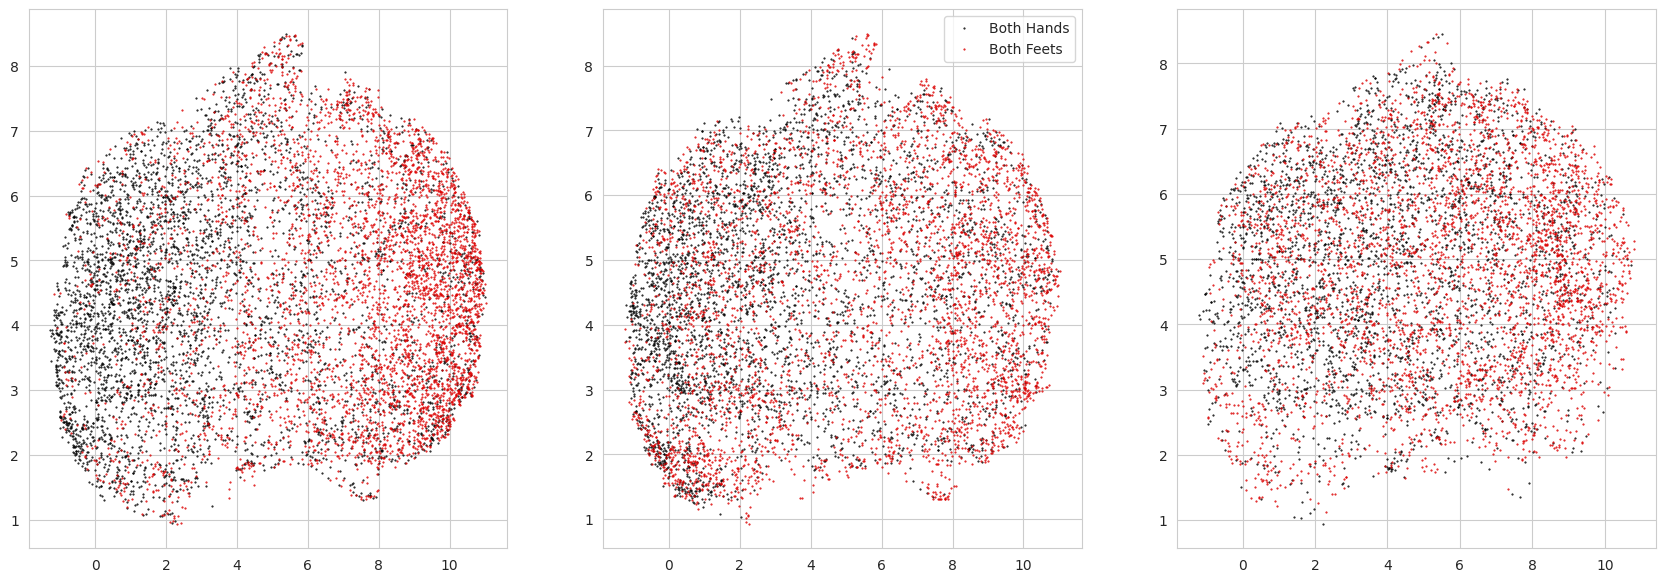

Train Accuracy: 67.63%
  Val Accuracy: 58.59%
 Test Accuracy: 55.50%


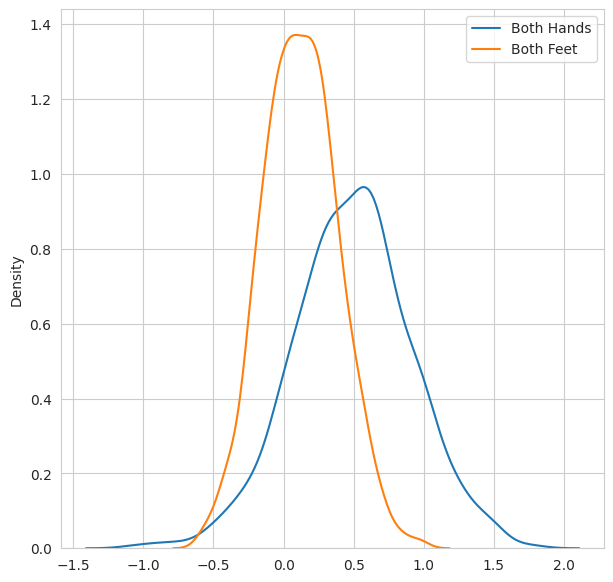

In [47]:
for sbj in '124567':
    output_dir = os.path.join(OUT_PATH,f'sub{sbj}_{now}')
    model.load_state_dict(torch.load(os.path.join(output_dir,'model.pt')))
    train_set,val_set,test_set,norm = prepare_data(os.path.join(DATA_PATH,f'sbj{sbj}_tr/preprocessed'))

    train_sampler = BaseSampler(train_set, shuffle=False, batch_size=eval_batch_size)
    val_sampler = BaseSampler(val_set, shuffle=False, batch_size=eval_batch_size)
    test_sampler = BaseSampler(test_set, shuffle=False, batch_size=eval_batch_size)
    show_stats_and_plots(model,train_sampler,val_sampler,test_sampler,save_dir=output_dir)

## Subject 1 from Paolo's Thesis

In [13]:
model.load_state_dict(torch.load(model_ckpt))

train_set,val_set,test_set = prepare_data(os.path.join(DATA_PATH,f'ss1/preprocessed'))

# Create samplers
episodic_sampler = EpisodicSampler(train_set,
                                n_support=n_support,
                                n_query=n_query,
                                n_episodes=n_episodes,
                                n_classes=n_classes)
train_sampler = BaseSampler(train_set, shuffle=False, batch_size=eval_batch_size)
val_sampler = BaseSampler(val_set, batch_size=eval_batch_size)
test_sampler = BaseSampler(test_set, shuffle=False, batch_size=eval_batch_size)

output_dir = os.path.join(OUT_PATH,f'ss1_{now}')
log_dir = os.path.join(LOG_PATH,f'ss1_{now}')

train(model,
    episodic_sampler,
    train_sampler,
    val_sampler,
    num_epochs,
    learning_rate=learning_rate,
    device=device,
    log_dir=log_dir,
    log_interval=log_interval,
    max_grad_norm=max_grad_norm,
    output_dir=output_dir,
    es_patience = es_patience,
    es_min_delta = es_min_delta,
    use_wandb = use_wandb,
    )

In [12]:
model.load_state_dict(torch.load(os.path.join(output_dir,'model.pt')))
show_stats_and_plots(model,train_sampler,val_sampler,test_sampler)